# Post Corona: From Crisis to Opportunity
#### 코로나 전후 MZ 세대의 투자행동 비교분석 

2020년 1월 등장한 코로나는 우리의 생활을 송두리째 뒤바꿔 놓았다.

거리두기 정책으로 사람들이 주로 외출을 자제하다보니 소비가 크게 줄어 내수 시장이 위축되었으며, 항공업, 관광업, 예술산업 등 수많은 산업들도 경제적 타격을 입었다.  

하지만 여기 코로나라는 위기를 통해 기회를 잡은 사람들이 있다. 전례없는 대규모 부의 이동이 주식 시장으로 이어졌고 과열된 투기 성향이 두드러졌다.
         
곳곳에서 주식시장에 처음으로 진입해 수익을 봤다는 사람들의 소식이 쏠쏠하게 들려온다. 

따라서 본 프로젝트에서는 코로나 전후의 시장 상황이 어떤지, 또 코로나 이후 진입한 투자자들의 특징은 무엇인지 분석해보고자 한다.      

-----------------------
[코드 순서]
    
    
0. Import 
   
   
1. EDA     
    1.1 고객 및 계좌 데이터        
    1.2 국내 거래 데이터       
    1.3 해외 거래 데이터      
    1.4 매도/매수 데이터     
    1.5 주식 상품 데이터      
  

    
2. Modeling    
    2.1 고객 투자성향 예측모델    
    2.2 투자성향에 중요한 변수? 
    
    
    
3. Influence of COVID19    
    3.1 시간 흐름에 따른 분석        
    3.2 코로나 전후 그룹 특성 비교분석  
    3.3 집단별 특성 비교분석
    
   
 
4. Insight  


5. Appendix     
    5.1 가설 검증      
    5.2 참고 자료

# 0. Import

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import warnings
warnings.filterwarnings("ignore")

from pyecharts.charts import Bar, Grid, Line, Liquid, Page, Pie, Timeline
from pyecharts import options as opts


pd.options.display.float_format = '{:.2f}'.format
col = px.colors.qualitative.Pastel

In [ ]:
act = pd.read_csv('2_act_info.csv')
cus = pd.read_csv('2_cus_info.csv')
iem = pd.read_csv('2_iem_info.csv')
trd_kr =  pd.read_csv('2_trd_kr.csv')
trd_oss =  pd.read_csv('2_trd_oss.csv')
cus = cus.astype({'tco_cus_grd_cd' : 'str'})
trd_kr['orr_dt'] = pd.to_datetime(trd_kr['orr_dt'].astype(str), format='%Y%m%d')
trd_oss['orr_dt'] = pd.to_datetime(trd_oss['orr_dt'].astype(str), format='%Y%m%d')

# 1. EDA

## 1.1 고객 및 계좌 데이터

In [ ]:
#연령대 카테고리 추가

cus.loc[(cus['cus_age'] >= 0) & (cus['cus_age'] < 10), 'age_cat'] = '10대 미만'
cus.loc[(cus['cus_age'] >= 10) & (cus['cus_age'] < 20), 'age_cat'] = '10대'
cus.loc[(cus['cus_age'] >= 20) & (cus['cus_age'] < 30), 'age_cat'] = '20대'
cus.loc[(cus['cus_age'] >= 30) & (cus['cus_age'] < 40), 'age_cat'] = '30대'
cus.loc[(cus['cus_age'] >= 40) & (cus['cus_age'] < 50),'age_cat'] = '40대'
cus.loc[(cus['cus_age'] >= 50) & (cus['cus_age'] < 60), 'age_cat'] = '50대'
cus.loc[(cus['cus_age'] >= 60) & (cus['cus_age'] < 70), 'age_cat'] = '60대'
cus.loc[cus['cus_age'] == 70, 'age_cat'] = '70대 이상'

#고객 등급, 투자성향 변수 변경

cus['tco_cus_grd_cd'] = cus['tco_cus_grd_cd'].replace({'01':'01 탑클래스','02':'02 골드','03':'03 로얄','04':'04 그린',
                                                       '05':'05 블루','09':'09 등급없음','_ ':'09 등급없음'})
cus['ivs_icn_cd'] = cus['ivs_icn_cd'].replace({'01':'01 안정형','02':'02 안정추구형','03':'03 위험중립형','04':'04 적극투자형',
                                               '05':'05 공격투자형','09':'09 전문투자자형','00':'정보 제공 미동의',
                                               '_ ':'등급없음', '_':'등급없음','-':'등급없음'})
cus = cus.rename({"sex_dit_cd":"sex", "cus_age":"age", "zip_ctp_cd": "home",
                  "tco_cus_grd_cd":"grade", "ivs_icn_cd":"ivst"},axis='columns')

In [ ]:
actcus = pd.merge(act,cus,on='cus_id')
act_cus = actcus[['act_id','cus_id','act_opn_ym']]
act_cus.to_csv('act_cus.csv', index=False) #고객정보와 계좌정보 연결한 데이터

In [ ]:
#개인당 국내계좌 개수 추출

count = {}
lists = list(actcus['cus_id'])

for i in lists:
    try: count[i] += 1
    except: count[i]=1
        
a = pd.DataFrame({'cus_id' : list(count.keys()), 
                  'num_act' : list(count.values())})

In [ ]:
cus_info = pd.merge(cus, a, on='cus_id') #고객정보 데이터(10000명)

In [ ]:
#고객별 등급 분포 시각화

df = cus_info.groupby(by=['age_cat', 'grade']).count()
df = df.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index()

fig = px.bar(df, x='age_cat', y='cus_id', color='grade',
             category_orders={"grade":['01 탑클래스','02 골드','03 로얄','04 그린','05 블루','09 등급없음'],
                             "age_cat": ["10대 미만","20대","30대","40대","50대","60대","70대 이상"]},
             labels={
                      "age_cat": "연령대",
                      "cus_id": "비율(%)",
                      "grade": "고객 등급"
                     },)

fig.update_layout(title='고객별 등급 분포')
fig.show()

우선 연령대별로 자산 규모를 확인해 보았습니다.
등급이 없는 경우 자산이 1000만원 이하라고 가정했습니다.

저희가 분석 대상으로 하는 2,30대는 자산 규모가 상대적으로 작습니다.    
특히 20대의 경우 자산이 3천만원 이하인 사람의 비중이 95%가 넘고, 30대의 경우 90%가 넘습니다.    
다시 말해, 2,30대는 **작은 규모**의 자산을 가지고 주식투자를 하고 있습니다.   

In [ ]:
#고객별 투자성향 분포 시각화

df = cus_info.groupby(by=['age_cat', 'ivst']).count()
df = df.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index()

fig = px.bar(df, x='age_cat', y='cus_id', color='ivst',
             category_orders={"age_cat": ["10대 미만","20대","30대","40대","50대","60대","70대 이상"],
                             "risk":['01 안정형','02 안정추구','03 위험중립형','04 적극투자형','05 공격투자형','09 전문투자자형','09 등급없음','정보 제공 미동의']},
             labels={
                      "age_cat": "연령대",
                      "cus_id": "비율(%)",
                      "ivst": "고객 투자 성향"
                     },)

fig.update_layout(title='고객별 투자성향 분포')
fig.show()

또 연령대별로 주관적인 투자 성향을 확인해보았습니다.

20대의 경우 타 연령층에 비해 안정형의 비율이 매우 높습니다.    
또한 20대에서 30대로 넘어가면서, 위험을 감수하는 성향이 많아집니다.

In [ ]:
#고객별 등급 분포 시각화

cus_info['risk'] = cus_info['ivst'].replace({'01 안정형':'01 위험회피형','02 안정추구형':'01 위험회피형','03 위험중립형':'02 위험중립형',
                                             '04 적극투자형':'03 위험감수형', '05 공격투자형':'03 위험감수형'})
df = cus_info.groupby(by=['grade','risk']).count()
df = df.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index()

fig = px.bar(df, x='grade', y='cus_id', color='risk',
             category_orders={"grade":['01 탑클래스','02 골드','03 로얄','04 그린','05 블루','09 등급없음'],
                              "risk": ['01 위험회피형','02 위험중립형','03 위험감수형','09 전문투자자형','등급없음','정보 제공 미동의']},
             labels={
                      "risk": "고객 투자 성향", 
                      "cus_id": "비율(%)",
                      "grade": "고객 등급"
                     },)

fig.update_layout(title='고객별 등급 분포')
fig.show()

자산 규모별 투자 성향을 확인해 보았습니다.

자산 규모가 클수록 위험을 감수하는 성향이 보이고, 작을수록 위험을 회피하는 성향이 보입니다.    
위에서 20대에서 30대로 넘어갈 때 투자성향의 분포가 바뀌는 게 자산 규모의 차이일지 확인해볼 필요성이 있습니다.   

투자 성향을 다음과 같은 세 단계로 분류합니다.    
전문투자자형은 전체 데이터에서 2명이기 때문에 제외했습니다.    
+ 위험회피형(risk-averse): 안정형, 안정추구형
+ 위험중립형(risk-neutral) : 위험 중립형
+ 위험감수형(risk-loving) : 적극투자형, 공격투자형

자산 규모도 다음과 같은 세 단계로 분류합니다.
+ 자산규모 하: ~ 자산 1000만원
+ 자산규모 중: 자산 1000만원 ~ 1억
+ 자산규모 상: 자산 1억 ~

In [ ]:
#2,30대 자산 규모 분류
cus_info['class'] = cus_info['grade'].replace({'01 탑클래스':'상','02 골드':'상','03 로얄':'상',
                                             '04 그린':'중', '05 블루':'중', '09 등급없음': '하'})

high_20 = cus_info.loc[(cus_info['age_cat']=='20대') & (cus_info['class'] == '상')]
middle_20 = cus_info.loc[(cus_info['age_cat']=='20대') & (cus_info['class'] == '중')]
low_20 = cus_info.loc[(cus_info['age_cat']=='20대') & (cus_info['class'] == '하')]
high_30 = cus_info.loc[(cus_info['age_cat']=='30대') & (cus_info['class'] == '상')]
middle_30 = cus_info.loc[(cus_info['age_cat']=='30대') & (cus_info['class'] == '중')]
low_30 = cus_info.loc[(cus_info['age_cat']=='30대') & (cus_info['class'] == '하')]

In [ ]:
risk = ['01 위험회피형','02 위험중립형','03 위험감수형']
color = ['#fc6472', '#f4b2a6', '#eccdb3', '#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c']
label = label_opts=opts.LabelOpts(color=["black"], formatter="{b}:\n{d}% \n ", font_size = 11)
h_20 = list(high_20.risk.value_counts().sort_index())
m_20 = list(middle_20.risk.value_counts().sort_index())
l_20 = list(low_20.risk.value_counts().sort_index())
h_30 = list(high_30.risk.value_counts().sort_index())
m_30 = list(middle_30.risk.value_counts().sort_index())
l_30 = list(low_30.risk.value_counts().sort_index())

tl = Timeline()
pie_0 = (Pie().add("", [list(z) for z in zip(risk, l_20)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 20대")).set_series_opts(label))
tl.add(pie_0, "20대 자산 하위그룹")
pie_1 = (Pie().add("", [list(z) for z in zip(risk, m_20)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 20대")).set_series_opts(label))
tl.add(pie_1, "20대 자산 중위그룹")
pie_2 = (Pie().add("", [list(z) for z in zip(risk, h_20)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 20대")).set_series_opts(label))
tl.add(pie_2, "20대 자산 상위그룹")

tl2 = Timeline()
pie_0 = (Pie().add("", [list(z) for z in zip(risk, l_30)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 30대")).set_series_opts(label))
tl2.add(pie_0, "30대 자산 하위그룹")
pie_1 = (Pie().add("", [list(z) for z in zip(risk, m_30)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 30대")).set_series_opts(label))
tl2.add(pie_1, "30대 자산 중위그룹")
pie_2 = (Pie().add("", [list(z) for z in zip(risk, h_30)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 30대")).set_series_opts(label))
tl2.add(pie_2, "30대 자산 상위그룹")
page = Page().add(tl,tl2)
page.render_notebook()

20대, 30대의 자산 규모 별 그룹에 따른 위험 회피정도를 시각화 해보았습니다.

20대의 경우 자산이 적으면 위험을 회피하려고 하지만, 30대는 자산이 적더라도 위험을 감수하려고 합니다.   
20대와 30대 모두 자산 상위그룹의 경우 위험을 감수하고자 하며, 30대의 경우 그 비율이 더 높습니다.   
이를 통해 Y&Z세대 내에서 위험을 감수하는 정도는 나이가 많아질수록, 또 자산 규모가 커질수록 높아진다고 볼 수 있습니다.

In [ ]:
#계좌 개수 시각화

fig = px.strip(cus_info, x="age_cat", y="num_act", color="class",
                category_orders={"age_cat": ["10대 미만","20대","30대","40대","50대","60대","70대 이상"],
                                'class':['하','중','상']},
                labels={
                        "age_cat": "연령대",
                        "num_act": "개수(개)",
                       })
fig.update_layout(title='고객별 계좌 개수')
pyo.iplot(fig)

고객 별 계좌 개수를 시각화해보았습니다.

나이가 많을수록 갖고 있는 계좌의 수가 많으며, 자산 규모가 커질수록 많음을 볼 수 있습니다.     
2,30대 내에서는 크게 차이가 두드러지진 않으나, 40대 이상에서는 그 차이가 극명합니다.

## 1.2 Korea Trading Data

In [ ]:
trd_kr = pd.merge(act_cus, trd_kr, on='act_id') #거래-고객 정보 데이터
trd_kr['amount'] = trd_kr['cns_qty']*trd_kr['orr_pr'] #거래별 금액 계산

In [ ]:
#고객별 종목 개수

a2 = dict(list(trd_kr[['cus_id','iem_cd']].groupby('cus_id')))
b2 = trd_kr.cus_id.unique().tolist()
e2 = []

for i in b2:
  c2 = a2[i]
  d2 = len(c2.iem_cd.unique())
  e2.append(d2)

df = pd.DataFrame({'cus_id': b2, 'iem_num_kr': e2})
cus_info = pd.merge(cus_info, df, on='cus_id',how='outer')

In [ ]:
kr = trd_kr.rename({'orr_rtn_hur':'ord','lst_cns_hur':'real','sby_dit_cd':'buysell', 
                        'orr_mdi_dit_cd':'store', 'cns_qty':'qty', 'orr_pr':'price'},axis='columns')

고객별 국내 투자 종목 개수를 뽑아 **iem_num_kr** 변수를 만듭니다.

In [ ]:
df = kr

#매도, 매수 데이터 분할
df_sell = df.loc[df['buysell']==1]
df_buy = df.loc[df['buysell']==2]
df_sell = df_sell.groupby(by=['act_id','iem_cd'], as_index=False)
df_buy = df_buy.groupby(by=['act_id','iem_cd'], as_index=False)

#종목별 매도/매수 주식개수 총합, 거래액 총합 계산
act_sell = df_sell.sum()[['act_id','iem_cd','qty','amount']].fillna(0)
act_buy = df_buy.sum()[['act_id','iem_cd','qty','amount']].fillna(0)

act_sell.rename(columns={'amount' : 'sell_amount_kr', 'qty':'sell_qty_kr'}, inplace=True)
act_buy.rename(columns={'amount' : 'buy_amount_kr', 'qty':'buy_qty_kr'}, inplace=True)

#종목별 매도/매수 건수 계산
count_sell = df_sell.count()[['act_id','iem_cd','buysell']].fillna(0)
count_buy = df_buy.count()[['act_id','iem_cd','buysell']].fillna(0)
count_sell.rename(columns={'buysell' : 'sell_num_kr'}, inplace=True)
count_buy.rename(columns={'buysell' : 'buy_num_kr'}, inplace=True)

#구한 값들을 합쳐줍니다.
df = pd.merge(act_sell, act_buy, on=['act_id','iem_cd'],how="outer")
df = pd.merge(df, count_sell, on=['act_id','iem_cd'],how="outer")
df = pd.merge(df, count_buy, on=['act_id','iem_cd'],how="outer")
trdkr = df.fillna(0) #한국: 계좌 - 종목별 매도/매수 건수, 총합 들어있는 데이터
trdkr['total_num_kr'] = trdkr['buy_num_kr'] + trdkr['sell_num_kr']

In [ ]:
#계좌별 매도/매수 건수 계산
trdkr2 = trdkr.groupby(trdkr['act_id']).sum()

#고객별 매도/매수 건수 계산
trdkr3 = pd.merge(trdkr2, act_cus, on=['act_id'])
trdkr4 = trdkr3.groupby(trdkr3['cus_id']).sum()
cus_info = pd.merge(trdkr4, cus_info, on=['cus_id'], how='outer')

종목별 국내 매도, 매수 주식 개수를 추출해 **sell_qty_kr**, **buy_qty_kr** 변수를 만듭니다.    
종목별 국내 매도, 매수 주식 개수를 추출해 **sell_amount_kr**, **buy_amount_kr** 변수를 만듭니다.    
종목별 국내 매도, 매수 주식거래 건수를 추출해 **sell_num_kr**, **buy_num_kr** 변수를 만들고, 둘을 합쳐 **total_num_kr** 변수를 만듭니다.

In [ ]:
#국내 거래 건수 시각화

df = cus_info.groupby(by=['age_cat']).median().reset_index()

trace3 = go.Bar(x=df.age_cat, y=df.sell_num_kr, name='매도',marker_color=col[0])
trace4 = go.Bar(x=df.age_cat, y=df.buy_num_kr, name='매수',marker_color=col[3])

data = [trace3, trace4]

layout = go.Layout(title='고객별 국내 거래 건수(중앙값)',barmode='stack')

fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

연령대별 매수, 매도 건수를 시각화 해보았습니다.

우선 눈에 띄는 특징으로는, 매수 건수가 매도 건수에 비해 2배가량 높습니다.   
이는 인간 심리의 특성으로 설명이 가능합니다.   
인간은 본능적으로 이익은 빨리 실현하려고 하고, 손실은 회피하려고 합니다.   
이에 따라서 사놓고 파는 행위를 지연해서 매수가 매도보다 많다고 볼 수 있습니다.    

또한 20대의 거래 건수는 매도와 매수 모두 다른 연령층에 비해서 낮습니다.    
시장진입 시기가 늦은 사람이 많아 상대적으로 짧은 기간 거래를 한 결과일 수 있으므로 뒤에서 다시 해석하도록 하겠습니다.

In [ ]:
#고객별 거래 빈도 계산(한달간 평균 거래 몇번?)

df = kr.groupby(['cus_id', 'orr_dt']).count().reset_index()
df_1 = df.set_index('orr_dt')
df_2 = df_1.groupby('cus_id').resample('M').sum()
df_3 = df_2.reset_index().set_index('orr_dt')
df_4 = df_3.groupby('cus_id').resample('Y').mean()
df_5 = df_4.reset_index()

import datetime as dt

df_5['year'] = df_5['orr_dt'].dt.year
df_7 = df_5[['cus_id', 'year', 'buysell']]
df_8 = df_7.pivot(index='cus_id',columns='year',values='buysell').reset_index()
df_8['freq_2019']=df_8[2019]
df_8['freq_2020']=df_8[2020]
cus_info = pd.merge(cus_info, df_8, on='cus_id', how='left')
cus_info.fillna(0)

df1 = cus_info.loc[cus_info['freq_2019']==0]
df2 = cus_info.loc[cus_info['freq_2019']>0]
df2['freq'] = (df2['freq_2019']+df2['freq_2020'])/2
df1['freq'] = df1['freq_2020']
cus_info['freq'] = pd.merge(df1,df2,on=['cus_id','freq'],how='outer')['freq']

In [ ]:
#고객별 거래빈도 시각화
df2 = cus_info.loc[cus_info['age_cat'] == '20대'].groupby(by=['grade']).median().reset_index()
df3 = cus_info.loc[cus_info['age_cat'] == '30대'].groupby(by=['grade']).median().reset_index()
df4 = cus_info.loc[cus_info['age_cat'] == '40대'].groupby(by=['grade']).median().reset_index()
df5 = cus_info.loc[cus_info['age_cat'] == '50대'].groupby(by=['grade']).median().reset_index()
df6 = cus_info.loc[cus_info['age_cat'] == '60대'].groupby(by=['grade']).median().reset_index()
df7 = cus_info.loc[cus_info['age_cat'] == '70대 이상'].groupby(by=['grade']).median().reset_index()

trace3 = go.Bar(x=df2.grade, y=df2.freq, name='20대',marker_color=col[0])
trace4 = go.Bar(x=df3.grade, y=df3.freq, name='30대',marker_color=col[1])
trace5 = go.Bar(x=df4.grade, y=df4.freq, name='40대',marker_color=col[2])
trace6 = go.Bar(x=df5.grade, y=df5.freq, name='50대',marker_color=col[3])
trace7 = go.Bar(x=df6.grade, y=df6.freq, name='60대',marker_color=col[4])
trace8 = go.Bar(x=df7.grade, y=df7.freq, name='70대 이상',marker_color=col[5])

fig = go.Figure(data=[trace3, trace4, trace5, trace6, trace7,trace8], layout=go.Layout(title='고객별 거래빈도'))
pyo.iplot(fig)

연령대별, 자산규모별 거래 빈도를 시각화 해보았습니다.

우선, 자산 규모와 거래 빈도는 크게 상관있어 보이지 않습니다.    
또 사람들은 평균적으로 한달에 6건 정도의 거래를 하는 것으로 보입니다.    
거래 빈도가 높은 것은 두가지 의미로 해석할 수 있습니다.     

- 종목의 개수가 많음

    종목의 개수가 많기 때문에 사고파는 경우의 수가 상대적으로 많다고 해석할 수 있습니다.       
    밑의 그래프를 보았을 때 종목의 개수가 많은 탑클래스의 빈도수가 적어, 종목 개수와는 크게 상관이 없는 것으로 보입니다.


- 단타 거래를 많이 함

    주식을 장기적으로 보유하기 보다는 주가의 흐름에 따라 단기에 사고파는 경우가 많다고 해석할 수 있습니다.       
    


In [ ]:
#고객별 상품 개수 시각화
df2 = cus_info.loc[cus_info['age_cat'] == '20대'].groupby(by=['grade']).median().reset_index()
df3 = cus_info.loc[cus_info['age_cat'] == '30대'].groupby(by=['grade']).median().reset_index()
df4 = cus_info.loc[cus_info['age_cat'] == '40대'].groupby(by=['grade']).median().reset_index()
df5 = cus_info.loc[cus_info['age_cat'] == '50대'].groupby(by=['grade']).median().reset_index()
df6 = cus_info.loc[cus_info['age_cat'] == '60대'].groupby(by=['grade']).median().reset_index()
df7 = cus_info.loc[cus_info['age_cat'] == '70대 이상'].groupby(by=['grade']).median().reset_index()

trace3 = go.Bar(x=df2.grade, y=df2.iem_num_kr, name='20대',marker_color=col[0])
trace4 = go.Bar(x=df3.grade, y=df3.iem_num_kr, name='30대',marker_color=col[1])
trace5 = go.Bar(x=df4.grade, y=df4.iem_num_kr, name='40대',marker_color=col[2])
trace6 = go.Bar(x=df5.grade, y=df5.iem_num_kr, name='50대',marker_color=col[3])
trace7 = go.Bar(x=df6.grade, y=df6.iem_num_kr, name='60대',marker_color=col[4])
trace8 = go.Bar(x=df7.grade, y=df7.iem_num_kr, name='70대',marker_color=col[5])

fig = go.Figure(data=[trace3, trace4, trace5, trace6, trace7,trace8], layout=go.Layout(title='고객별 상품 개수'))
pyo.iplot(fig)

## 1.3 Overseas Trading Data

In [ ]:
trd_oss = pd.merge(act_cus, trd_oss, on='act_id') #거래-고객 정보 데이터
trd_oss['amount'] = trd_oss['cns_qty']*trd_oss['orr_pr']*trd_oss['trd_cur_xcg_rt'] #거래별 금액 계산

In [ ]:
#고객별 종목 개수

a2 = dict(list(trd_oss[['cus_id','iem_cd']].groupby('cus_id')))
b2 = trd_oss.cus_id.unique().tolist()
e2 = []

for i in b2:
  c2 = a2[i]
  d2 = len(c2.iem_cd.unique())
  e2.append(d2)

df = pd.DataFrame({'cus_id': b2, 'iem_num_oss': e2})
cus_info = pd.merge(cus_info, df, on='cus_id',how='outer')

In [ ]:
oss = trd_oss.rename({'orr_rtn_hur':'ord','lst_cns_hur':'real','sby_dit_cd':'buysell', 
                      'orr_mdi_dit_cd':'store', 'cns_qty':'qty', 'orr_pr':'price',
                      'cur_cd':'country','trd_cur_xcg_rt':'rate'},axis='columns')

In [ ]:
df = oss

#매도, 매수 데이터 분할
df_sell = df.loc[df['buysell']==1]
df_buy = df.loc[df['buysell']==2]
df_sell = df_sell.groupby(by=['act_id','iem_cd'], as_index=False)
df_buy = df_buy.groupby(by=['act_id','iem_cd'], as_index=False)

#고객, 종목별 매도/매수 주식개수 총합, 거래액 총합 계산
act_sell = df_sell.sum()[['act_id','iem_cd','qty','amount']].fillna(0)
act_buy = df_buy.sum()[['act_id','iem_cd','qty','amount']].fillna(0)

act_sell.rename(columns={'amount' : 'sell_amount_oss', 'qty':'sell_qty_oss'}, inplace=True)
act_buy.rename(columns={'amount' : 'buy_amount_oss', 'qty':'buy_qty_oss'}, inplace=True)

#고객, 종목별 매도/매수 건수 계산
count_sell = df_sell.count()[['act_id','iem_cd','buysell']].fillna(0)
count_buy = df_buy.count()[['act_id','iem_cd','buysell']].fillna(0)
count_sell.rename(columns={'buysell' : 'sell_num_oss'}, inplace=True)
count_buy.rename(columns={'buysell' : 'buy_num_oss'}, inplace=True)

#구한 값들을 합쳐줍니다.
df = pd.merge(act_sell, act_buy, on=['act_id','iem_cd'],how="outer")
df = pd.merge(df, count_sell, on=['act_id','iem_cd'],how="outer")
df = pd.merge(df, count_buy, on=['act_id','iem_cd'],how="outer")
trdoss = df.fillna(0) #해외: 계좌 - 종목별 매도/매수 건수, 총합 들어있는 데이터
trdoss['total_num_oss'] = trdoss['buy_num_oss'] + trdoss['sell_num_oss']

In [ ]:
#계좌별 매도/매수 건수 계산
trdoss2 = trdoss.groupby(trdoss['act_id']).sum()

#고객별 매도/매수 건수 계산
trdoss3 = pd.merge(trdoss2, act_cus, on=['act_id'])
trdoss4 = trdoss3.groupby(trdoss3['cus_id']).sum()
cus_info = pd.merge(trdoss4, cus_info, on=['cus_id'], how='outer')

종목별 해외 매도, 매수 주식 개수를 추출해 **sell_qty_oss**, **buy_qty_oss** 변수를 만듭니다.    
종목별 해외 매도, 매수 주식 액수를 추출해 **sell_amount_oss**, **buy_amount_oss** 변수를 만듭니다.    
종목별 해외 매도, 매수 주식거래 건수를 추출해 **sell_num_oss**, **buy_num_oss** 변수를 만들고, 둘을 합쳐 **total_num_oss** 변수를 만듭니다.    

In [ ]:
#해외 거래 건수 비율 시각화(해외거래를 한 사람에 한해서)

df = cus_info
df['ratio'] = 100*df['total_num_oss']/(df['total_num_oss']+df['total_num_kr'])
df = df.loc[df['total_num_oss'] > 0]

fig = px.box(df, x="age_cat", y="ratio", color="age_cat",
                category_orders={"age_cat": ["10대 미만","20대","30대","40대","50대","60대","70대 이상"]},
                labels={
                        "age_cat": "연령대",
                        "ratio": "비율(%)",
                       })
fig.update_layout(title='고객별 전체 거래 대비 해외 거래 건수')
pyo.iplot(fig)

전체 거래 대비 해외 거래 건수를 살펴보았을 때, 30대의 비율이 비교적 낮은 편임을 확인할 수 있었습니다.   
즉, 30대는 국내 거래를 위주로 하고, 20대는 30대에 비해 상대적으로 해외 투자를 많이 합니다.

또한 해외투자는 조금 더 신세대인 2,30대가 할 법하다고 생각할 수 있는데, 이와 달리 10대 미만과 60대에서 해외투자의 비율이 매우 높습니다.    
이는 시장의 해외투자가 개인이 아닌 PB(Private Banker)에 의해 이루어지고 있음을 의심해볼 수도 있습니다.    
그래서 상대적으로 자산규모가 낮고, 개인 투자를 하는 2,30대의 해외 투자 비율이 낮아진다고 생각할 수도 있습니다.    

In [ ]:
#국내, 해외 거래 상품개수 시각화

df1 = cus_info.loc[cus_info['total_num_oss'] > 0]
df1 = df1.groupby(by=['age_cat']).median().reset_index()
df = cus_info.groupby(by=['age_cat']).median().reset_index()

trace3 = go.Bar(x=df.age_cat, y=df.iem_num_kr, name='국내 상품',marker_color=col[0])
trace4 = go.Bar(x=df1.age_cat, y=df1.iem_num_oss, name='해외 상품',marker_color=col[3])

data = [trace3, trace4]

layout = go.Layout(title='고객별 상품 개수(중앙값)')

fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

보유하고 있는 종목 개수에 있어서도 해외 상품의 개수가 국내 상품보다 현저히 적습니다.      
또한 연령대별로도 거의 차이가 나지 않습니다.    
이는 우리나라에서 해외주식 직접투자가 가능해진지 얼마 되지 않았기 때문일 확률이 높습니다.

사람들은 평균적으로 10개 정도 종목에 분산투자를 하고 있으며, 30대의 경우 12개로 조금 더 높습니다.

## 1.4 Trading Data - When?

### 1.4.1 Korea Trading Data

In [ ]:
df = kr
df = df.sort_values(by=["act_id", "iem_cd","orr_dt","orr_ord"], ascending=[True, True,True,True]).reset_index()
df = df[['act_id','iem_cd','buysell','price','qty','amount','orr_dt','orr_ord']]

n = df.groupby(by=['act_id','iem_cd'], as_index=False).count()['orr_dt'].tolist()
lowsell_col,highsell_col,lowbuy_col,highbuy_col,act_col,iem_col = [],[],[],[],[],[]
r=0
price = df['price'].tolist()
buysell = df['buysell'].tolist()
act = df['act_id'].tolist()
iem = df['iem_cd'].tolist()

for k in range(311922):
    risk,lowsell,highsell,lowbuy,highbuy = 0,0,0,0,0
    for i in range(n[k]-1):
        if price[i]>price[i+1] and buysell[i+1] == 1:
            lowsell = lowsell + 1
        elif price[i]<=price[i+1] and buysell[i+1] == 1:
            highsell = highsell + 1
        elif price[i]>price[i+1] and buysell[i+1] == 2:
            lowbuy = lowbuy + 1
        elif price[i]<=price[i+1] and buysell[i+1] == 2:
            highbuy = highbuy + 1
    lowsell_col.append(lowsell)
    highsell_col.append(highsell)
    lowbuy_col.append(lowbuy)
    highbuy_col.append(highbuy)
    
trdkr = trdkr.sort_values(by=["act_id", "iem_cd"], ascending=[True, True])
data = {'act_id': trdkr['act_id'], 'iem_cd': trdkr['iem_cd'], 'lowsell_kr': lowsell_col,
       'highsell_kr': highsell_col, 'lowbuy_kr': lowbuy_col, 'highbuy_kr': highbuy_col}
data = pd.DataFrame(data)
trdkr = pd.merge(trdkr, data, on=['act_id','iem_cd'])

trdkr['a'] = trdkr['total_num_kr']
trdkr['a'] = trdkr['a'].replace({1:2})
trdkr['lowsell_kr'] = trdkr['lowsell_kr']/(trdkr['a']-1)
trdkr['highsell_kr'] = trdkr['highsell_kr']/(trdkr['a']-1)
trdkr['lowbuy_kr'] = trdkr['lowbuy_kr']/(trdkr['a']-1)
trdkr['highbuy_kr'] = trdkr['highbuy_kr']/(trdkr['a']-1)
trdkr = trdkr.drop('a',axis=1)

거래 성향을 파악하기 위해 직전 거래에 비해 가격이 올랐는지 내렸는지 여부와 함께 매도, 매수 여부를 구합니다.     
각각의 비중을 구해 다음과 같은 네가지 변수를 추가해주었습니다.

+ lowsell_kr: 주가 떨어졌을 때 매도
+ highsell_kr: 주가 올랐을 때 매도
+ lowbuy_kr: 주가 떨어졌을 때 매수
+ highbuy_kr: 주가 올랐을 때 매수

In [ ]:
#고객별 평균값 구해주기
a = ['lowsell_kr','highsell_kr','lowbuy_kr','highbuy_kr']
data = trdkr.groupby(pd.merge(act_cus, trdkr, on=['act_id'])['cus_id']).mean()[a]
cus_info = pd.merge(data, cus_info, on=['cus_id'],how = 'outer')

cus_info[a]=cus_info[a]*100

In [ ]:
a = ['lowsell_kr','highsell_kr','lowbuy_kr','highbuy_kr']
list(cus_info.mean()[a])


[0.7142855365721484, 1.992319977694955, 67.20883014474258, 20.511044856572894]

In [ ]:
#연령별 매도/매수 성향 비율 시각화

pie1 = (
    Pie()
    .add("", [list(z) for z in zip(list(cus_info.mean()[a].index), list(cus_info.mean()[a]))], radius=[60, 120])
    .set_global_opts(title_opts=opts.TitleOpts(title="매도/매수 성향 비율 시각화"),
                    legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='20%', pos_top ='middle'))
    .set_series_opts(label_opts=opts.LabelOpts(color=["black"], formatter="{d}%", font_size = 11))
)

pie1.render_notebook()

매도/매수 성향 비율을 시각화 해보았습니다.

따로 자산규모별, 연령별, 투자성향별 비율을 시각화 해보았지만, 차이가 1% 내외로 매우 작았습니다.    
투자자들의 거래 행동을 살펴보면, 다음과 같이 정리할 수 있습니다.

+ 추격매수
    
  가격이 내려갈 때 저점이라고 생각해서 매수: 거래 행동의 대다수(65% 이상)을 차지
    
  가격이 올라갈 때 상승할 것이라고 생각해서 매수: 거래 행동의 20% 이상을 차지
    
    
+ 손절매

  가격이 내려갈 때 손해를 방지하기 위해 매도: 거래행동의 약 0.7% 차지
  
  
  

+ 익절매

  가격이 올라갈 때 차익을 얻기 위해 매도: 거래행동의 약 2% 차지
    
    
이러한 양상은 앞서 언급했었던 손해를 미루고 이익을 추구하는 인간의 기본 심리와도 관련이 있습니다.     
또한 매수에 있어서도 오르고 있는 주식을 사기 보다는, 가격이 내려가는 주식을 사려고 합니다.      
이는 투자성향이나 자산규모, 연령과 상관없이 비율이 비슷하게 나옵니다.

In [ ]:
cus_info = cus_info.fillna(0)

#계좌-상품별 순매수금액 구하기
trdkr['net_purchase_kr']=trdkr['buy_amount_kr']-trdkr['sell_amount_kr']
trdoss['net_purchase_oss']=trdoss['buy_amount_oss']-trdoss['sell_amount_oss']

#고객별 순매수금액 구하기
cus_info['net_purchase_kr']=cus_info['buy_amount_kr']-cus_info['sell_amount_kr']
cus_info['net_purchase_oss']=cus_info['buy_amount_oss']-cus_info['sell_amount_oss']

#필요한 coulmn만 추출
cus_info = cus_info[['cus_id','age_cat','sex','grade','class','risk', 'ivst', 'home', 'num_act', 'iem_num_kr',
                     'iem_num_oss', 'lowsell_kr', 'highsell_kr', 'lowbuy_kr', 'highbuy_kr',
                     'sell_qty_kr', 'sell_amount_kr', 'buy_qty_kr', 'buy_amount_kr',
                     'sell_num_kr', 'buy_num_kr', 'total_num_kr',
                     'sell_qty_oss', 'sell_amount_oss', 'buy_qty_oss', 'buy_amount_oss',
                     'sell_num_oss', 'buy_num_oss', 'total_num_oss',
                     'net_purchase_kr','net_purchase_oss','freq_2019','freq_2020','freq']]

여러 주식투자 분석 레포트에서 '순매수금액 및 비중'을 중요한 지표로 활용하는 것을 보았습니다.    
그래서 순매수 금액을 추출해 **net_purchase_kr**과 **net_purchase_oss** 변수를 추가했습니다.

## 1.5 주식 상품 데이터

In [ ]:
#상장법인목록 불러오기
ind_code = pd.read_csv('상장법인목록.csv', engine = 'python', dtype = 'str').reset_index()
iem = pd.read_csv('2_iem_info.csv')

#column명 바꾸기
ind_code.rename(columns = {'level_2':'industry', 'level_1':'stock_code'}, inplace=True)
ind_code['stock_code']=ind_code['stock_code'].astype(str)
ind_code['stock_code']=ind_code['stock_code'].str.zfill(6)

#종목코드에서 숫자만 추출 (상장법인목록과 비교 위해)
iem["stock_code"] = iem["iem_cd"].str[1:7]

#종목코드를 기준으로 item과 ind_code merge
item_n = pd.DataFrame(pd.merge(iem, ind_code, on='stock_code', how='left'))

#불필요한 열 제거
item_n = item_n[['iem_cd', 'iem_eng_nm', 'iem_krl_nm', 'industry']]

상장법인목록에서 구별된 업종의 개수가 너무 많아, 이를 10개의 산업으로 분류했습니다.  
분류 기준은 기업 재무정보 대표 업체인 에프앤가이드에서 만든 Fn universe라는 분류체계를 따랐습니다.  
* 산업 분류: 에너지, 소재, 산업재, 경기소비재, 필수소비재, 의료, 금융, IT, 통신서비스, 유틸리티

In [ ]:
에너지 = ['연료용 가스 제조 및 배관공급업','기타 섬유제품 제조업', '석유 정제품 제조업', '해체, 선별 및 원료 재생업', '석탄 광업', '전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업']

소재 = ['자연과학 및 공학 연구개발업', '유리 및 유리제품 제조업', '기초 화학물질 제조업', '골판지, 종이 상자 및 종이용기 제조업',  '기타 화학제품 제조업',  '펄프, 종이 및 판지 제조업', '기타 종이 및 판지 제품 제조업',
 '플라스틱제품 제조업', '합성고무 및 플라스틱 물질 제조업', '특수 목적용 기계 제조업', '기타 비금속광물 광업', '1차 비철금속 제조업',  '기타 금속 가공제품 제조업', '금속 주조업',  '기타 비금속 광물제품 제조업', '화학섬유 제조업','나무제품 제조업', '고무제품 제조업',  '무기 및 총포탄 제조업', '내화, 비내화 요업제품 제조업',
 '제재 및 목재 가공업', '가구 제조업', '시멘트, 석회, 플라스터 및 그 제품 제조업']

산업재 = ['절연선 및 케이블 제조업', '선박 및 보트 건조업', '그외 기타 제품 제조업', '1차 철강 제조업', '해상 운송업', '건물 건설업',  '육상 여객 운송업', '기타 운송관련 서비스업',
 '기반조성 및 시설물 축조관련 전문공사업',  '철도장비 제조업', '실내건축 및 건축마무리 공사업', '건축자재, 철물 및 난방장치 도매업', '건물설비 설치 공사업','도로 화물 운송업', '자동차 판매업', '산업용 기계 및 장비 임대업', 
 '구조용 금속제품, 탱크 및 증기발생기 제조업','운송장비 임대업', '기타 전기장비 제조업', '도축, 육류 가공 및 저장 처리업',  '항공 여객 운송업', '그외 기타 운송장비 제조업', '기타 과학기술 서비스업', '항공기,우주선 및 부품 제조업', 
 '그외 기타 전문, 과학 및 기술 서비스업', '건축기술, 엔지니어링 및 관련 기술 서비스업', '폐기물 처리업',  '측정, 시험, 항해, 제어 및 기타 정밀기기 제조업; 광학기기 제외',
 '증기, 냉·온수 및 공기조절 공급업',  '일반 목적용 기계 제조업', '전기업', '토목 건설업']

경기소비재 = ['자동차 재제조 부품 제조업', '상품 중개업', '섬유, 의복, 신발 및 가죽제품 소매업','상품 종합 도매업', '봉제의복 제조업', '여행사 및 기타 여행보조 서비스업',  '기타 상품 전문 소매업',  '교육지원 서비스업', 
 '일반 교습 학원',   '텔레비전 방송업', '오디오물 출판 및 원판 녹음업', '창작 및 예술관련 서비스업', '경비, 경호 및 탐정업',   '초등 교육기관', '기타 교육기관',  '회사 본부 및 경영 컨설팅 서비스업',
 '광고업', '기타 전문 서비스업',  '일반 및 생활 숙박시설 운영업', '기타 사업지원 서비스업', '전문디자인업',  '유원지 및 기타 오락관련 서비스업', '종합 소매업'
 '음식점업', '그외 기타 개인 서비스업', '직물직조 및 직물제품 제조업', '무점포 소매업', '편조원단 제조업', '섬유제품 염색, 정리 및 마무리 가공업', '기타 전문 도매업', 
 '스포츠 서비스업', '산업용 농·축산물 및 동·식물 도매업',  '사업시설 유지·관리 서비스업', '자동차 신품 부품 제조업', '자동차용 엔진 및 자동차 제조업',
 '가전제품 및 정보통신장비 소매업',  '영화, 비디오물, 방송프로그램 제작 및 배급업', '자동차 부품 및 내장품 판매업',  '연료 소매업','방적 및 가공사 제조업', 
 '기계장비 및 관련 물품 도매업',  '가죽, 가방 및 유사제품 제조업', '신발 및 신발 부분품 제조업', '악기 제조업',  '귀금속 및 장신용품 제조업', '인쇄 및 인쇄관련 산업', '서적, 잡지 및 기타 인쇄물 출판업',
 '전구 및 조명장치 제조업','기타 섬유제품 제조업', '기타 생활용품 소매업', '음식점업', '종합 소매업', '가정용 기기 제조업']

필수소비재 = ['음·식료품 및 담배 도매업', '담배 제조업', '생활용품 도매업', '개인 및 가정용품 임대업', '기타 생활용품 소매업'
 '가정용 기기 제조업',  '비알코올음료 및 얼음 제조업', '알코올음료 제조업', '동물용 사료 및 조제식품 제조업', 
 '곡물가공품, 전분 및 전분제품 제조업', '과실, 채소 가공 및 저장 처리업', '작물 재배업', '기타 식품 제조업', '수산물 가공 및 저장 처리업',
 '낙농제품 및 식용빙과류 제조업']

의료 = ['의약품 제조업', '기초 의약물질 및 생물학적 제제 제조업', '의료용품 및 기타 의약 관련제품 제조업',
 '의료용 기기 제조업',  '비료, 농약 및 살균, 살충제 제조업', '환경 정화 및 복원업', '어로 어업']

금융 = ['기타 금융업', '보험업',  '은행 및 저축기관',  '부동산 임대 및 공급업',
'재 보험업',  '신탁업 및 집합투자업', '금융 지원 서비스업']

IT = ['통신 및 방송 장비 제조업', '전자부품 제조업', '자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업', '소프트웨어 개발 및 공급업', '반도체 제조업', '컴퓨터 프로그래밍, 시스템 통합 및 관리업',
'컴퓨터 및 주변장치 제조업',  '기타 정보 서비스업', '기록매체 복제업', '영상 및 음향기기 제조업',  '사진장비 및 광학기기 제조업', '일차전지 및 축전지 제조업']

통신서비스 = ['전기 통신업', '전기 및 통신 공사업']

In [ ]:
def ind(x) :
    if x in 에너지:
        return "에너지"
    elif x in 소재:
        return "소재"
    elif x in 산업재:
        return "산업재"
    elif x in 경기소비재:
        return "경기소비재"
    elif x in 필수소비재:
        return "필수소비재"
    elif x in 의료:
        return "의료"
    elif x in 금융:
        return "금융"
    elif x in IT:
        return "IT"
    elif x in 통신서비스:
        return "통신서비스"
    else:
        return "기타"
    
item_n["ind_cat"] = item_n["industry"].apply(lambda x : ind(x))

In [ ]:
#회사이름에 투자나 증권이 들어가면 금융으로 분류
for i in range(0, len(item_n)):
    if item_n.ind_cat[i] == '기타':
        if '투자' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '금융'
            item_n.industry[i] = '신탁업 및 집합투자업'
        elif '증권' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '금융'
            item_n.industry[i] = '신탁업 및 집합투자업'
        else: item_n.ind_cat[i] = '기타'
    else:
        item_n.ind_cat[i] = item_n.ind_cat[i]

In [ ]:
#우선주라 분류가 되지 않은 종목 분류
for i in range(0, len(item_n)):
    if item_n.ind_cat[i] == '기타':
        if '자동차' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '경기소비재'
        elif '전자' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = 'IT'
        elif '성신양회' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '소재'
        elif '대원전선' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '산업재'
        elif '서울식품' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '필수소비재'
        elif '크라운' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '필수소비재'
        elif '중공업' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '산업재'
        elif '화학' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '소재'
        elif '전기' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = 'IT'
        elif '삼성SDI' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = 'IT'
        elif '보험' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '금융'
        elif '은행' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '금융'
        elif '푸드' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '필수소비재'
        elif '약품' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '의료'
        elif '항공' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '산업재'   
        elif '한진' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '산업재'
        elif '대교' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '경기소비재'
        elif '바이오' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '의료'
        elif '남양' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '필수소비재'
        elif '미래에셋' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '금융'
        elif '건설' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '산업재'
        elif '두산' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '산업재'
        elif '타이어' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '소재'   
        elif '페이퍼' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '소재'
        elif '대림' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '산업재'
        elif '에스마크' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = 'IT'
        elif 'Oil' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '에너지'
        elif '소재' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '소재'   
        elif '유니슨' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '에너지'
        elif '사조해표' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '필수소비재'
        elif '생활건강' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '필수소비재'
        elif '진로' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '필수소비재'
        elif '칠성' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '필수소비재'
        elif '제약' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '의료'
        elif '호텔' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = '경기소비재'
        elif '정보' in item_n.iem_krl_nm[i]:
            item_n.ind_cat[i] = 'IT'
        else: item_n.ind_cat[i] = '기타'
    else:
        item_n.ind_cat[i] = item_n.ind_cat[i]

In [ ]:
df = pd.merge(trdkr, item_n, on='iem_cd')

#필요한 column만 추출
df = df[['act_id','iem_cd','net_purchase_kr','iem_krl_nm','ind_cat']]
#고객별 순매수금액 비중 구하기
net = pd.merge(df, act_cus, on=['act_id']).groupby(by = ['cus_id','iem_cd']).sum()
net = net.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index()
#종목 분류별 순매수금액 비중 구하기
cat_net = pd.merge(net,item_n, on='iem_cd')
cat_net = cat_net.groupby(by = ['cus_id','ind_cat']).sum()
cat_net = cat_net.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index()
cat = cat_net['ind_cat'].unique().tolist()
df2 = pd.DataFrame(cus_info['cus_id'])
for i in cat:
    df1 = cat_net[cat_net['ind_cat']==i][['cus_id','net_purchase_kr']]
    df1.rename(columns ={'net_purchase_kr':i}, inplace = True)
    df2 = pd.merge(df2, df1, on='cus_id', how='outer')
df2 = df2.fillna(0)

#비중 cus_info 데이터에 합쳐주기
cus_info = pd.merge(cus_info, df2, on='cus_id')

In [ ]:
df = pd.merge(trdkr, item_n, on='iem_cd')
df = df[['act_id','iem_cd','net_purchase_kr','iem_krl_nm','ind_cat']]
df = pd.merge(act_cus, df, on = 'act_id')
data_ind = pd.merge(cus_info, df, on = 'cus_id')

drop_20 = data_ind[data_ind['age_cat'] == '20대']
drop_30 = data_ind[data_ind['age_cat'] == '30대']
drop_40 = data_ind[data_ind['age_cat'] == '40대']
drop_50 = data_ind[data_ind['age_cat'] == '50대']
drop_60 = data_ind[data_ind['age_cat'] == '60대']
drop_70 = data_ind[data_ind['age_cat'] == '70대 이상']

In [ ]:
#연령대별 top10 인기 종목 시각화

count_20 = list(drop_20.iem_krl_nm.value_counts())[:10]
stock_20 = list(drop_20.iem_krl_nm.value_counts().index)[0:10]
count_30 = list(drop_30.iem_krl_nm.value_counts())[:10]
stock_30 = list(drop_30.iem_krl_nm.value_counts().index)[0:10]
count_40 = list(drop_40.iem_krl_nm.value_counts())[:10]
stock_40 = list(drop_40.iem_krl_nm.value_counts().index)[0:10]
count_50 = list(drop_50.iem_krl_nm.value_counts())[:10]
stock_50 = list(drop_50.iem_krl_nm.value_counts().index)[0:10]
count_60 = list(drop_60.iem_krl_nm.value_counts())[:10]
stock_60 = list(drop_60.iem_krl_nm.value_counts().index)[0:10]
count_70 = list(drop_70.iem_krl_nm.value_counts())[:10]
stock_70 = list(drop_70.iem_krl_nm.value_counts().index)[0:10]

bar_20 = (
    Bar().add_xaxis(stock_20).add_yaxis("20대 Top10", count_20, color=color[0])
    .set_global_opts(title_opts=opts.TitleOpts(title="20대", pos_top = '5%', pos_left="38%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_30 = (
    Bar().add_xaxis(stock_30).add_yaxis("30 대 Top10", count_30, color=color[2])
    .set_global_opts(title_opts=opts.TitleOpts(title="30대", pos_top = '5%',pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_40 = (
    Bar().add_xaxis(stock_40).add_yaxis("40대 Top10", count_40, color=color[2])
    .set_global_opts(title_opts=opts.TitleOpts(title="40대", pos_top = '39%', pos_left="38%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_50 = (
    Bar().add_xaxis(stock_50).add_yaxis("50 대 Top10", count_50, color=color[3])
    .set_global_opts(title_opts=opts.TitleOpts(title="50대", pos_top = '39%', pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_60 = (
    Bar().add_xaxis(stock_60).add_yaxis("60대 Top10", count_60, color=color[4])
    .set_global_opts(title_opts=opts.TitleOpts(title="60대",pos_top = '68%',  pos_left="38%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_70 = (
    Bar().add_xaxis(stock_70).add_yaxis("70 대 Top10", count_70, color=color[5])
    .set_global_opts(title_opts=opts.TitleOpts(title="70대", pos_top = '68%', pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15)),
                     legend_opts=opts.LegendOpts(is_show = False))) 
grid = (
    Grid()
    .add(bar_20, grid_opts=opts.GridOpts(pos_top = '10%', pos_bottom = '70%', pos_right="55%"))
    .add(bar_30, grid_opts=opts.GridOpts(pos_top = '10%', pos_bottom = '70%', pos_left="55%"))
    .add(bar_40, grid_opts=opts.GridOpts(pos_top = '40%', pos_bottom = '40%', pos_right="55%"))
    .add(bar_50, grid_opts=opts.GridOpts(pos_top = '40%', pos_bottom = '40%', pos_left="55%"))
    .add(bar_60, grid_opts=opts.GridOpts(pos_top = '67%', pos_right="55%"))
    .add(bar_70, grid_opts=opts.GridOpts(pos_top = '67%', pos_left="55%"))
)
grid.render_notebook()

연령대별 TOP 10 인기 종목을 시각화 해보았습니다.

우선 대체적으로 제약관련 종목이 인기가 많음을 확인할 수 있습니다. 
이는 저희 주제와 마찬가지로 코로나가 주식시장에  전 연령대에 있어 영향을 주고 있음을 의미하고 있습니다. 

주목해서 볼만한 점은, 20대의 인기 종목이 살짝 다르다는 점입니다.   
우선 상위 10개 종목 중 유일하게 우선주 투자가 이루어진 항목이 있습니다.        
아무래도 대학생, 사회초년생의 비율이 높다보니 의사결정권 대신 보통주보다 높은 수익률을 보장하는 우선주에 높은 관심을 보이는 것 같습니다.
또 시가총액이 높은 대형주의 비율이 타 연령층에 비해 높습니다.    
이는 주식을 시작한지 얼마 되지 않아 위험회피적인 성향을 띈다고 볼 수 있습니다.    
실제로 20대에 위험 회피적인 성향을 띄는 투자자가 절반 가까이 되었습니다.

**[시가총액 Top 10 기업]**    
삼성전자  
SK하이닉스  
삼성전자우  
LG화학  
삼성바이오로직스  
셀트리온  
NAVER  
삼성SDI  
현대차  
카카오  




In [ ]:
#보유 종목 개수로 순위 계산
high = drop_20[drop_20['class'] == '상']
mid = drop_20[drop_20['class'] == '중']
low = drop_20[drop_20['class'] == '하']

count_high = list(high.iem_krl_nm.value_counts())[:10]
stock_high = list(high.iem_krl_nm.value_counts().index)[0:10]
count_mid = list(mid.iem_krl_nm.value_counts())[:10]
stock_mid = list(mid.iem_krl_nm.value_counts().index)[0:10]
count_low = list(low.iem_krl_nm.value_counts())[:10]
stock_low = list(low.iem_krl_nm.value_counts().index)[0:10]

bar_21 = (
    Bar().add_xaxis(stock_high).add_yaxis("20대 상위그룹 Top10", count_high, color=[color[0]])
    .set_global_opts(title_opts=opts.TitleOpts(title="20대 상", pos_top = '5%', pos_left="38%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_22 = (
    Bar().add_xaxis(stock_mid).add_yaxis("20대 중위그룹 Top10", count_mid, color=[color[1]])
    .set_global_opts(title_opts=opts.TitleOpts(title="20대 중", pos_top = '39%', pos_left="38%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_23 = (
    Bar().add_xaxis(stock_low).add_yaxis("20대 하위그룹 Top10", count_low, color=[color[2]])
    .set_global_opts(title_opts=opts.TitleOpts(title="20대 하",pos_top = '68%',  pos_left="38%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))

In [ ]:
high = drop_30[drop_30['class'] == '상']
mid = drop_30[drop_30['class'] == '중']
low = drop_30[drop_30['class'] == '하']

count_high = list(high.iem_krl_nm.value_counts())[:10]
stock_high = list(high.iem_krl_nm.value_counts().index)[0:10]
count_mid = list(mid.iem_krl_nm.value_counts())[:10]
stock_mid = list(mid.iem_krl_nm.value_counts().index)[0:10]
count_low = list(low.iem_krl_nm.value_counts())[:10]
stock_low = list(low.iem_krl_nm.value_counts().index)[0:10]

bar_31 = (
    Bar().add_xaxis(stock_high).add_yaxis("30대 상위그룹 Top10", count_high, color=[color[3]])
    .set_global_opts(title_opts=opts.TitleOpts(title="30대 상", pos_top = '5%', pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_32 = (
    Bar().add_xaxis(stock_mid).add_yaxis("30대 중위그룹 Top10", count_mid, color=[color[4]])
    .set_global_opts(title_opts=opts.TitleOpts(title="30대 중", pos_top = '39%', pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_33 = (
    Bar().add_xaxis(stock_low).add_yaxis("30대 하위그룹 Top10", count_low, color=[color[5]])
    .set_global_opts(title_opts=opts.TitleOpts(title="30대 하",pos_top = '68%',  pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
grid = (
    Grid()
    .add(bar_21, grid_opts=opts.GridOpts(pos_top = '10%', pos_bottom = '70%', pos_right="55%"))
    .add(bar_31, grid_opts=opts.GridOpts(pos_top = '10%', pos_bottom = '70%', pos_left="55%"))
    .add(bar_22, grid_opts=opts.GridOpts(pos_top = '40%', pos_bottom = '40%', pos_right="55%"))
    .add(bar_32, grid_opts=opts.GridOpts(pos_top = '40%', pos_bottom = '40%', pos_left="55%"))
    .add(bar_23, grid_opts=opts.GridOpts(pos_top = '67%', pos_right="55%"))
    .add(bar_33, grid_opts=opts.GridOpts(pos_top = '67%', pos_left="55%"))
)
grid.render_notebook()

**[20대]** 

자산 규모 별로 구분한 20대 고객의 상위 10개 종목은 상위 그룹, 중위 그룹, 하위 그룹 모두 전반적으로 비슷합니다. 공통적으로 삼성전자보통주가 가장 높은 비중을 차지하고 있으며, 시가총액 10위 이내의 기업들이 많이 포함되어 있습니다.
 
 그러나 눈 여겨봐야할 점은 각 종목들의 가격입니다. 상위 그룹에만 있는 삼성바이오로직스보통주, 삼성SDI보통주, LG화학보통주의 가격은 각각 82,6000원, 62,8000원, 82,4000원으로 상당히 높습니다. 중위 그룹에서는 30만원 후반대의 카카오보통주, 셀트리온보통주가 가장 가격이 높으며, 하위 그룹에서 30만원 이상의 종목은 카카오보통주만 존재합니다.
 
 자산 규모가 큰 20대 고객들은 높은 가격의 종목들도 많이 보유하고 있지만, 자산 규모가 천 만원 이내의 고객들은 대체로 10만원 전 후의 비교적 저렴한 종목들을 주로 보유하고 있습니다.
 
**[30대]**    

 자산 규모 별로 구분한 30대 고객의 상위 10개 종목도 20대와 비슷하게 삼성전자보통주가 가장 높은 비중을 차지하고 있습니다. 그러나 20대와 다르게 상위 그룹, 중위 그룹, 하위 그룹의 종목들이 가격적인 측면에서 유의미한 차이가 있지는 않습니다. 하지만 전체적인 종목의 구성에서 여러 비교를 해볼 수가 있습니다.
 
 먼저, 시가총액이 10위 이내의 기업들이 20대 상위 종목에는 많이 포함되어 있는 반면, 30대 상위 종목에는 비교적 적게 포함되어 있습니다. 이는 20대는 안전추구형이 많고, 30대는 위험을 감수하는 성향이 많은 것과 관련하여 생각해볼 수 있습니다.
 
 또한, 20대와 다르게 제약, 바이오 관련 종목들이 많이 포함되어 있습니다.     
 이는 코로나19 상황과 관련하여 생각해볼 수 있을 것 같아 밑에서 더 논의하도록 하겠습니다.
 
- 상위 그룹: 셀트리온보통주, 씨젠, 신라젠, 셀트리온헬스케어, 파미셀보통주       
- 중위 그룹: 파미셀보통주, 신풍제약보통주, 씨젠, 이원다이애그노믹스            
- 하위 그룹: 씨젠, 신풍제약보통주, 파미셀              

In [ ]:
df = data_ind[['cus_id', 'ind_cat']]
df = df.drop_duplicates()
df = df.groupby('cus_id').count().reset_index()
cus_info = pd.merge(cus_info, df, on ='cus_id', how = 'outer').fillna(0)

#고객별 종목산업개수 시각화
df2 = cus_info.loc[cus_info['age_cat'] == '20대'].groupby(by=['grade']).median().reset_index()
df3 = cus_info.loc[cus_info['age_cat'] == '30대'].groupby(by=['grade']).median().reset_index()
df4 = cus_info.loc[cus_info['age_cat'] == '40대'].groupby(by=['grade']).median().reset_index()
df5 = cus_info.loc[cus_info['age_cat'] == '50대'].groupby(by=['grade']).median().reset_index()
df6 = cus_info.loc[cus_info['age_cat'] == '60대'].groupby(by=['grade']).median().reset_index()
df7 = cus_info.loc[cus_info['age_cat'] == '70대 이상'].groupby(by=['grade']).median().reset_index()

trace3 = go.Bar(x=df2.grade, y=df2.ind_cat, name='20대',marker_color=col[0])
trace4 = go.Bar(x=df3.grade, y=df3.ind_cat, name='30대',marker_color=col[1])
trace5 = go.Bar(x=df4.grade, y=df4.ind_cat, name='40대',marker_color=col[2])
trace6 = go.Bar(x=df5.grade, y=df5.ind_cat, name='50대',marker_color=col[3])
trace7 = go.Bar(x=df6.grade, y=df6.ind_cat, name='60대',marker_color=col[4])
trace8 = go.Bar(x=df7.grade, y=df7.ind_cat, name='70대',marker_color=col[5])

fig = go.Figure(data=[trace3, trace4, trace5, trace6, trace7,trace8], layout=go.Layout(title='고객별 산업 개수'))
pyo.iplot(fig)

고객별 투자 포트폴리오의 다양성을 알아보기 위해 산업의 개수를 시각화해보았습니다.

확실히 자산 규모가 높은 탑클래스의 경우 종목의 개수가 많은만큼 투자하는 산업의 가지수도 다양합니다.     
20대 탑클래스의 경우 평균적으로 모든 산업의 상품을 가지고 투자하고 있었습니다.         
포트폴리오가 다양할수록 자산규모가 높아짐을 확인할 수 있습니다.

In [ ]:
#시가총액 순위목록 불러오기
firm = pd.read_csv('firm.csv')
firm.rename(columns ={'종목코드':'stock_code'}, inplace = True)
firm = firm[['순위','stock_code','종목명']]
#300위내 - 중대형주/ 300위 밖 - 소형주
firm_300 = firm.loc[0:299]
firm_300['firm_scale'] = 'big_firm'
firm_300 = firm_300[['stock_code','firm_scale']]
firm = pd.merge(firm, firm_300, on='stock_code',how='outer')
firm = firm.fillna('small_firm')[['stock_code','firm_scale']]
#시가총액 파일 item_n에 합쳐주기
a = pd.merge(iem, firm, on='stock_code', how='left')

In [ ]:
#종목 분류별 순매수금액 비중 구하기
sca_net = pd.merge(net,a, on='iem_cd')
sca_net = sca_net.groupby(by = ['cus_id','firm_scale']).sum()
sca_net = sca_net.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index()
sca = sca_net['firm_scale'].unique().tolist()
df2 = pd.DataFrame(cus_info['cus_id'])
for i in sca:
    df1 = sca_net[sca_net['firm_scale']==i][['cus_id','net_purchase_kr']]
    df1.rename(columns ={'net_purchase_kr':i}, inplace = True)
    df2 = pd.merge(df2, df1, on='cus_id', how='outer')
df2 = df2.fillna(0)
df2.rename(columns ={0.0:'small_firm', 1.0:'big_firm'}, inplace = True)

#비중 cus_info 데이터에 합쳐주기
cus_info = pd.merge(cus_info, df2, on='cus_id')

# 2. Modeling

## 2.1 투자성향 예측모델

In [ ]:
cus_info['lowsell_total'] = cus_info['lowsell_kr'] + cus_info['lowsell_oss']
cus_info['highsell_total'] = cus_info['highsell_kr'] + cus_info['highsell_oss']
cus_info['lowbuy_total'] = cus_info['lowbuy_kr'] + cus_info['lowbuy_oss']
cus_info['highbuy_total'] = cus_info['highbuy_kr'] + cus_info['highbuy_oss']
cus_info['net_purchase_total'] = cus_info['net_purchase_kr'] + cus_info['net_purchase_oss']

In [ ]:
#코로나 이전 이후 그룹 나누기

df = pd.merge(kr,oss,on=['cus_id','orr_dt'],how='outer')
df = df.groupby(by=['cus_id']).min()

from datetime import datetime
df1 = df.loc[df['orr_dt']<datetime(2020, 1, 1)].reset_index()
df2 = df.loc[df['orr_dt']>datetime(2020, 1, 1)].reset_index()

df1['covid']='before'
df2['covid']='after'

df1 = df1[['cus_id','covid']]
df2 = df2[['cus_id','covid']]

df = pd.merge(df1,df2,on=['cus_id','covid'],how='outer')
cus_info = pd.merge(cus_info,df,on=['cus_id'],how='outer')

해외와 한국의 케이스를 모두 포괄할 수 있는 **_total** 변수를 만듭니다

In [ ]:
cus_info_test = cus_info.loc[(cus_info['ivst'] == '등급없음') | (cus_info['ivst'] == '정보 제공 미동의')]
cus_info_1 = cus_info.loc[(cus_info['ivst'] != '등급없음') & (cus_info['ivst'] != '정보 제공 미동의')]

정보가 제공되지 않은 데이터를 테스트 셋으로 설정합니다. 정보가 제공된 데이터를 이용하여 적절한 예측모델을 적합한다면 이들의 등급을 예측할 수 있습니다.

In [ ]:
target = []

for i in cus_info_1['ivst']:
    if i == '안정형':
        target.append(0)
    elif i == '안정추구형':
        target.append(0)
    elif i == '위험중립형':
        target.append(1)
    elif i == '공격투자형':
        target.append(2)
    elif i == '적극투자형':
        target.append(2)
    else:
        target.append(3)
        
cus_info_1['target'] = target

투자성향을 크게 세 부류로 나누고(안정/중립/위험), 예측의 대상이 되는 타깃변수로 지정하였습니다.

In [ ]:
cus_info_2 = cus_info_1.dropna(axis=0)
cus_info_nan = cus_info_1[cus_info_1['covid'].isnull()]

In [ ]:
covidd = []

for i in cus_info_2['covid']:
    if i == 'after':
        covidd.append(1)
    else:
        covidd.append(0)

cus_info_2['covid'] = covidd

'covid'변수는 이항변수인 만큼 그 결측치를 대체하기가 쉽지 않아 결측치가 존재하는 행을 제외하였습니다.
'covid'변수가 0/1의 값 중 하나를 취하도록 변환하였습니다

In [ ]:
cus_info_df = cus_info_2[['age_cat', 'sex', 'grade', 'num_act', 'covid', 'lowsell_total',
                          'highsell_total', 'lowbuy_total', 'highbuy_total', 'net_purchase_total']]

cus_info_target = cus_info_2['target']

cus_info_df를 설명변수, cus_info_target을 관심변수로 설정합니다

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cus_info_df[['lowsell_total', 'highsell_total', 'lowbuy_total', 'highbuy_total', 'net_purchase_total']] = scaler.fit_transform(cus_info_df[['lowsell_total', 'highsell_total', 'lowbuy_total',
                                              'highbuy_total', 'net_purchase_total']])

정규화를 거치지 않을 경우 단위 등에 의해 매우 큰 값을 가지게 되는 수치형 변수가 예측에 막대한 영향을 끼치게 됩니다. 이를 방지하고자 MinMaxScaler를 적용하여 데이터를 정규화하였습니다.

In [ ]:
gradee = []

for i in cus_info_df['grade']:
    if i == '등급없음':
        gradee.append(0)
        
    elif i == '블루':
        gradee.append(1)
        
    elif i == '그린':
        gradee.append(2)
    
    elif i == '로얄':
        gradee.append(3)
    
    elif i == '골드':
        gradee.append(4)
        
    elif i == '탑클래스':
        gradee.append(5)

cus_info_df['grade'] = gradee

'grade'변수를 머신러닝 모델이 인식할 수 있는 형태로 전환하였습니다. 'grade'변수는 순서형 변수이므로 추후에 사용될 pd.get_dummies를 사용하지 않았습니다. pd.get_dummies는 범주형 변수를 수치형 가변수로 전환합니다.

In [ ]:
cus_info_df = pd.get_dummies(cus_info_df)

나이대를 표현하는 'age_cat'변수는 값들 사이의 관계성이 없기 때문에 pd.get_dummies를 사용하여 가변수로 전환합니다.

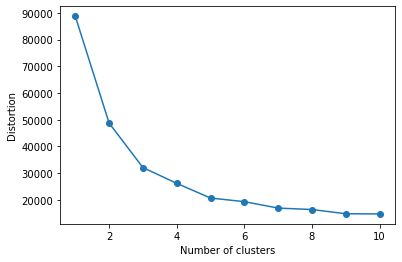

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

distortions = []

for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(cus_info_df)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

 비지도학습의 일종인 K-평균 방식을 사용하였습니다. 비지도학습의 경우 예측의 대상이되는 타깃 변수를 사용하지 않고, 설명변수들 만을 사용하여 주어진 데이터를 k개의 군집으로 분류합니다. 적절한 k를 구하고자 k의 변동에 따른 오류의 변화를 그래프로 나타냈습니다. k가 5이상인 경우부터는 오류가 유의미하게 감소되지 않으므로 적절한 군집의 개수 k는 4입니다. 실제로 타깃변수가 크게 4가지로 분류되는 것을 고려하면 합리적인 결과입니다.

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(cus_info_df, cus_info_target,
                                                       test_size=0.2,  random_state=11)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4346, 16) (1087, 16) (4346,) (1087,)


모델의 학습을 위해 주어진 데이터를 분할합니다

In [ ]:
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error

lgb_dtrain = lgb.Dataset(data=X_train, label=y_train)
lgb_param = {'max_depth' : 10,
             'learning_rate' : 0.81,
             'n_estimators' : 400,
             'objective' : 'regression'}

lgb_model = lgb.train(params=lgb_param, train_set=lgb_dtrain)
lgb_model_predict = lgb_model.predict(X_test)

print('RMSE : {}'.format(sqrt(mean_squared_error(lgb_model_predict, y_test))))

RMSE : 0.9500054322190713


지도학습 분류모델 중 가장 유용하게 쓰이는 알고리즘인 lightgbm을 적용시켰습니다.

In [ ]:
import shap
import skimage

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

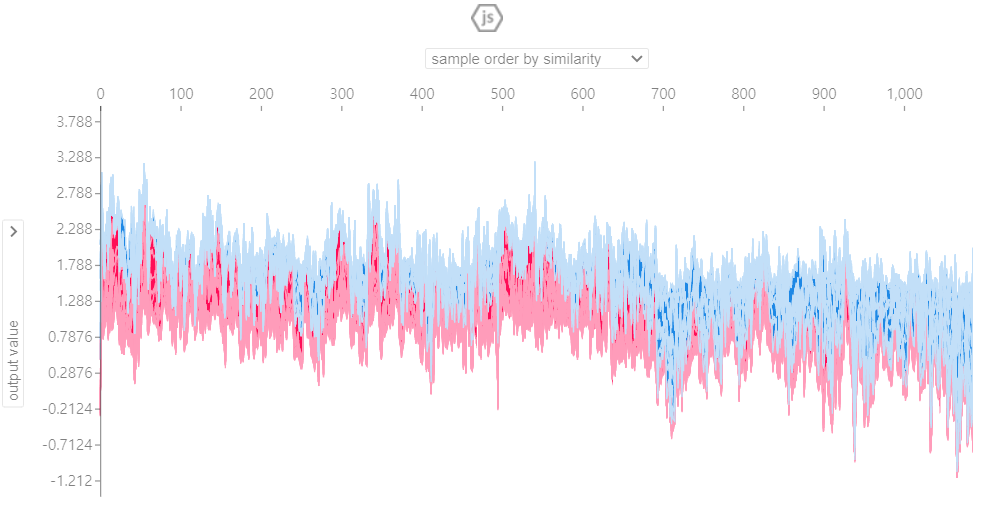

In [ ]:
from IPython.display import Image

Image('0.png')

force_plot은 개별 모델의 예측을 시각화하는 plot으로 각 데이터별 변수들의 영향도를 볼 수 있습니다.
빨간색이 영향도가 높으며, 파란색이 영향도가 낮습니다.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0, :])

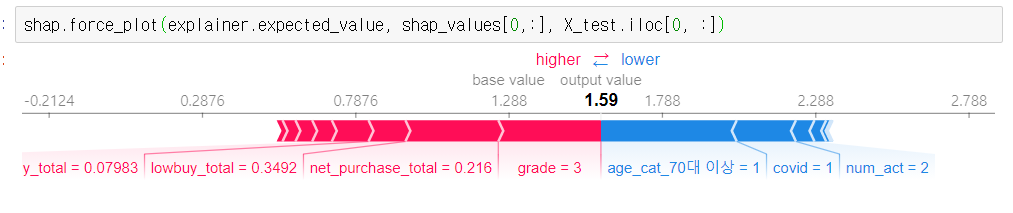

In [ ]:
Image('1.png')

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1, :])

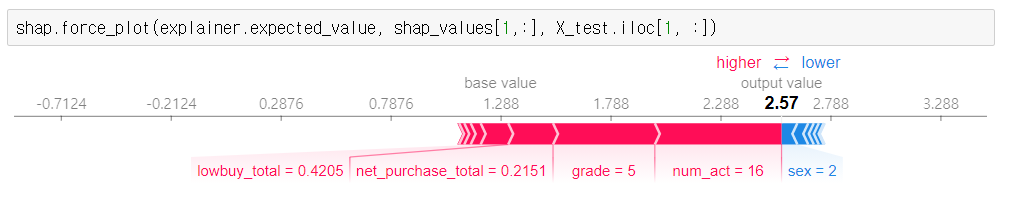

In [ ]:
Image('2.png')

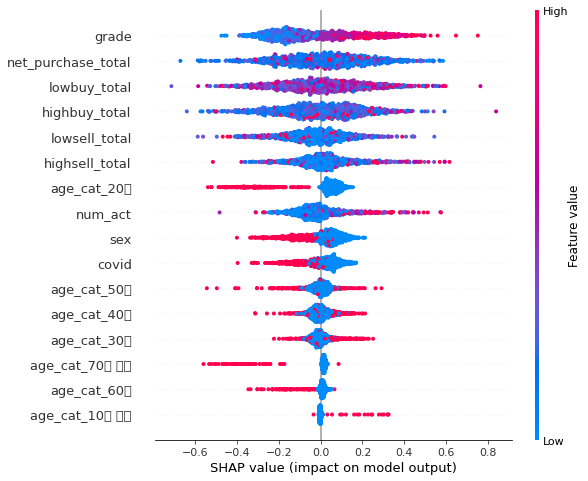

In [ ]:
shap.summary_plot(shap_values, X_test)

보다 직관적인 이해를 위해 summary plot을 사용할 수 있습니다.     
자산 규모가 커질수록 투자성향은 공격적이게 됩니다.     
또한 코로나 이후 진입했을 때 투자성향이 안정적일 확률이 더 높습니다.     
성별의 경우도 여자가 더 안정적인 성향을 띄게됩니다. 

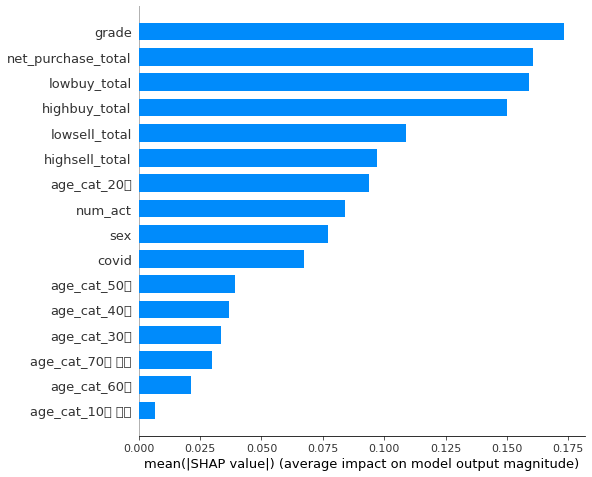

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

summary_plot을 막대 그래프 형식으로 나타냈습니다.    
위 그래프는 여러 트리모델에서 사용할 수 있는 feature_importance와 같은 기능을 한다고 볼 수 있습니다.     
각 변수에 대한 shap value의 절대값으로 각 변수들의 중요도를 파악할 수 있습니다.

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ll = Lasso(alpha=0.01)
ll.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

각 변수들의 중요도를 파악하기 위해 일종의 변수 선택 기능을 하는 라쏘 회귀를 적용시켰습니다.   
라쏘 회귀는 설명변수의 개수가 증가하는 것에 페널티를 부여하여, 유의하지 않은 개별 변수들의 영향력을 0으로 축소합니다.

In [ ]:
ll.coef_

array([-0.11439215,  0.13143029,  0.01478192, -0.07840506, -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.31791311,  0.03943511,  0.04796841,  0.        , -0.        ,
       -0.11401581])

학습이 완료된 라쏘 회귀모델의 계수들 중 일부가 0의 값을 갖는 것을 확인할 수 있습니다.

In [ ]:
var_coef = pd.DataFrame({'variables': cus_info_df.columns,
              'coefs': ll.coef_}).sort_values(by='coefs',
                                              ascending=False)
var_coef

,variables,coefs
1,grade,0.13
12,age_cat_40대,0.05
11,age_cat_30대,0.04
2,num_act,0.01
4,lowsell_total,-0.00
5,highsell_total,-0.00
6,lowbuy_total,-0.00
7,highbuy_total,0.00
8,net_purchase_total,0.00
9,age_cat_10대 미만,0.00


앞서 다뤘던 lgbm과 다른 점도 있지만 공통적으로 자산규모, 코로나 전후, 성별 변수가 유의한 것을 확인 할 수 있습니다

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

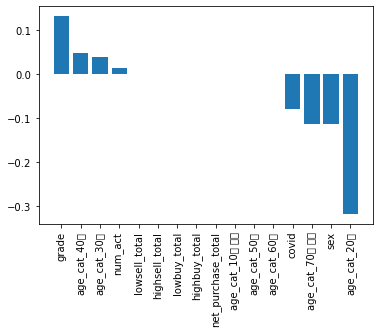

In [ ]:
plt.bar(var_coef['variables'], var_coef['coefs'])
plt.xticks(rotation=90)

# 3. Influence of COVID19

또한 저희는 고객의 투자성향에 가장 큰 영향을 미치는 변수로 시장진입 시기의 코로나 전후 여부가 있음을 확인했습니다.    
그래서 코로나라는 변수가 주식 시장과 고객에 미치는 영향이 크다고 판단하는 것이 합리적이라고 생각해, 코로나 전후의 데이터를 비교분석해 보았습니다.    
우선 코로나19 전후 시장 상황을 파악해보고, 코로나19 이전에 주식투자를 한 사람과 이후에 주식투자를 한 사람의 특성을 비교했습니다.

## 3.1 시간 흐름에 따른 데이터 분석

In [ ]:
df = kr
df_date = df[['orr_dt', 'buysell', 'price']]
df_date = df_date.groupby(['orr_dt', 'buysell']).sum()

net_purchase = []

for i in range(0, len(df_date['price'])):
    if i % 2 == 0:
        a = df_date['price'][i+1] - df_date['price'][i]
        net_purchase.append(a)
        
date = []

for i in range(0, len(df_date['price'])):
    if i % 2 == 0:
        date.append(df_date.index[i][0])
        
date_buy = pd.DataFrame({'date' : date, 'net_purchase' : net_purchase})
date_buy = date_buy.set_index('date') 
dff = date_buy.resample('W').mean().reset_index()

우선 데이터를 통해서 일주일별로 주식 순매수 금액이 어떻게 되는지 구해보았습니다.

In [ ]:
df = pd.merge(df, cus_info, on='cus_id')
df2 = df.loc[df['age_cat'] == '20대']
df_date = df2[['orr_dt', 'buysell', 'price']]
df_date = df_date.groupby(['orr_dt', 'buysell']).sum()

net_purchase = []

for i in range(0, len(df_date['price'])):
    if i % 2 == 0:
        a = df_date['price'][i+1] - df_date['price'][i]
        net_purchase.append(a)
        
date = []

for i in range(0, len(df_date['price'])):
    if i % 2 == 0:
        date.append(df_date.index[i][0])
        
date_buy = pd.DataFrame({'date' : date, 'net_purchase' : net_purchase})
date_buy = date_buy.set_index('date') 
df_20 = date_buy.resample('W').mean().reset_index()

In [ ]:
df3 = df.loc[df['age_cat'] == '30대']
df_date = df3[['orr_dt', 'buysell', 'price']]
df_date = df_date.groupby(['orr_dt', 'buysell']).sum()

net_purchase = []

for i in range(0, len(df_date['price'])):
    if i % 2 == 0:
        a = df_date['price'][i+1] - df_date['price'][i]
        net_purchase.append(a)
        
date = []

for i in range(0, len(df_date['price'])):
    if i % 2 == 0:
        date.append(df_date.index[i][0])
        
date_buy = pd.DataFrame({'date' : date, 'net_purchase' : net_purchase})
date_buy = date_buy.set_index('date') 
df_30 = date_buy.resample('W').mean().reset_index()

저희의 분석대상인 2,30대의 경우도 일주일별 주식 순매수 금액을 구해보았습니다.

In [ ]:
df4 = df.loc[(df['age_cat'] != '20대') & (df['age_cat'] != '30대')]
df_date = df4[['orr_dt', 'buysell', 'price']]
df_date = df_date.groupby(['orr_dt', 'buysell']).sum()

net_purchase = []

for i in range(0, len(df_date['price'])):
    if i % 2 == 0:
        a = df_date['price'][i+1] - df_date['price'][i]
        net_purchase.append(a)
        
date = []

for i in range(0, len(df_date['price'])):
    if i % 2 == 0:
        date.append(df_date.index[i][0])
        
date_buy = pd.DataFrame({'date' : date, 'net_purchase' : net_purchase})
date_buy = date_buy.set_index('date') 
df_2030 = date_buy.resample('W').mean().reset_index()

In [ ]:
cospi = pd.read_csv('코스피지수 내역.csv')

In [ ]:
cospi

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2020년 06월 30일,"2,108.33","2,124.38","2,134.38","2,108.26",708.60M,0.71%
1,2020년 06월 29일,"2,093.48","2,105.54","2,120.50","2,087.84",643.16M,-1.93%
2,2020년 06월 26일,"2,134.65","2,137.47","2,142.04","2,115.25",761.04M,1.05%
3,2020년 06월 25일,"2,112.37","2,130.45","2,143.33","2,112.37",1.02B,-2.27%
4,2020년 06월 24일,"2,161.51","2,145.93","2,171.86","2,143.91",913.90M,1.42%
...,...,...,...,...,...,...,...
364,2019년 01월 08일,"2,025.27","2,038.68","2,042.70","2,023.59",397.83M,-0.58%
365,2019년 01월 07일,"2,037.10","2,034.24","2,048.06","2,030.90",440.19M,1.34%
366,2019년 01월 04일,"2,010.25","1,992.40","2,011.56","1,984.53",408.99M,0.83%
367,2019년 01월 03일,"1,993.70","2,011.81","2,014.72","1,991.65",427.98M,-0.81%


그래프 구현을 위해 2,30대 외의의 경우도 일주일별 주식 순매수 금액을 구해보았습니다.

In [ ]:
#순매수 금액 흐름

trace3 = go.Bar(x=df_20.date, y=df_20.net_purchase, name='20대',marker_color=col[6])
trace4 = go.Bar(x=df_30.date, y=df_30.net_purchase, name='30대',marker_color=col[5])
trace5 = go.Bar(x=df_2030.date, y=df_2030.net_purchase, name='그 외',marker_color=col[10])

data = [trace3, trace4, trace5]

layout = go.Layout(title='순매수 금액 흐름', barmode='stack')

fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

일주일별 순매수 금액 흐름을 시각화 해보았습니다

2020년 1월을 기점으로 순매수 금액이 폭발적으로 증가함을 볼 수 있습니다.
이 때 최근 10년간 주가의 최저치를 찍었었습니다.   
소위 '개미'라고 불리우는, 주가가 떨어지면서 하락장에 참여한 매수자들이 매우 많았던 시기입니다.     
이 때 늘어난 순매수금액에 2,30대의 비중도 늘어나는 것처럼 보이는데, 더 확실하게 알아보기 위해 그래프를 그려보았습니다.

In [ ]:
df = pd.merge(df_20,df_30, on='date')
df = pd.merge(df,dff,on='date')

df['s20'] = df['net_purchase_x']/df['net_purchase']
df['s30'] = df['net_purchase_y']/df['net_purchase']

#순매수 금액 흐름

trace3 = go.Bar(x=df.date, y=df.s20, name='20대',marker_color=col[6])
trace4 = go.Bar(x=df.date, y=df.s30, name='30대',marker_color=col[5])
data = [trace3, trace4]

layout = go.Layout(title='순매수 금액 비중')

fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

30대의 경우 코로나19를 기점으로 순매수 금액이 늘어났다고 보기는 어렵지만, 20대의 경우 차지하는 비율이 2배 이상 증가함을 볼 수 있습니다.    
코로나19 이후 주식시장에 유입된 인구중 상당수가 20대이며, 이들의 매수량이 많이 늘어났다고 할 수 있습니다.

In [ ]:
final_data = pd.merge(kr, item_n, on='iem_cd')
final_data[final_data['ind_cat'] == '기타']
df_c = pd.DataFrame(final_data.groupby(['orr_dt', 'ind_cat'])['buysell'].count())
df_c.unstack()

a1 = list(df_c.unstack().sort_index()['buysell']['에너지'])
b1 = list(df_c.unstack().sort_index()['buysell']['소재'])
c1 = list(df_c.unstack().sort_index()['buysell']['산업재'])
d1 = list(df_c.unstack().sort_index()['buysell']['경기소비재'])
e1 = list(df_c.unstack().sort_index()['buysell']['필수소비재'])
f1 = list(df_c.unstack().sort_index()['buysell']['의료'])
g1 = list(df_c.unstack().sort_index()['buysell']['금융'])
h1 = list(df_c.unstack().sort_index()['buysell']['IT'])
i1 = list(df_c.unstack().sort_index()['buysell']['통신서비스'])
j1 = list(df_c.unstack().sort_index()['buysell']['기타'])

date = df_c.unstack().sort_index()['buysell']['에너지'].index.tolist() 

In [ ]:
#날짜별 산업 거래 건수 시각화

line_chart = (
        Line()
        .add_xaxis(date)
        .add_yaxis("에너지", a1, color='skyblue')
        .add_yaxis("소재", b1, color='orange')
        .add_yaxis("산업재", c1, color='pink')
        .add_yaxis("경기소비재", d1, color='red')
        .add_yaxis("필수소비재", e1, color='black')
        .add_yaxis("의료", f1, color='blue')
        .add_yaxis("금융", g1, color='green')
        .add_yaxis("IT", h1, color='purple')
        .add_yaxis("통신서비스", i1, color='darkblue')
        .add_yaxis("기타", i1, color='gray')
    
        .set_global_opts(title_opts=opts.TitleOpts(title="산업별 거래"),
                         xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
                         datazoom_opts=[opts.DataZoomOpts(), opts.DataZoomOpts(type_="inside")])
        .set_series_opts(label_opts=opts.LabelOpts(position="top", color=["black"]))
)
line_chart.render_notebook()

산업별 종목의 일별 거래 횟수를 시각화하여 그 거래 흐름을 살펴보았습니다.   

전반적으로 주식 거래가 <span style="color:blue"> 2020년을 분기점으로 활발해짐</span>을 확인할 수 있습니다.       
특히, 의료 부문의 거래 빈도가 2020년 이후 가파르게 증가하였는데 이는 코로나19 상황과 관련이 있다고 보입니다.      
또한, 의료 부문 거래가 가장 활발하게 이루어진 2020년 3월은 코로나19가 대유행하던 시기와 맞물립니다.

In [ ]:
#고객별 거래빈도 시각화
df = cus_info.groupby(by=['age_cat']).median().reset_index()

trace3 = go.Bar(x=df.age_cat, y=df.freq_2019, name='2019년',marker_color=col[0])
trace4 = go.Bar(x=df.age_cat, y=df.freq_2020, name='2020년',marker_color=col[3])

fig = go.Figure(data=[trace3, trace4], layout=go.Layout(title='고객별 거래빈도(한달)'))
pyo.iplot(fig)

거래 빈도를 살펴보더라도 2020년의 평균 거래빈도가 2배이상 늘었음을 확인할 수 있습니다.

이는 코로나로 인해 활발해진 시장 거래의 모습을 보여주고 있습니다.     
특히 20대의 거래 빈도가 2.5건에서 8건으로, 30대는 3.5건에서 9건으로 폭발적으로 늘었습니다.       
코로나 이후 20,30대가 거래에 활발히 참여하고 있다고 해석할 수 있습니다.      

## 3.2 코로나 전후 그룹 특성 비교분석

In [ ]:
#코로나 이전 이후 그룹 나누기

df = pd.merge(kr,oss,on=['cus_id','orr_dt'],how='outer')
df = df.groupby(by=['cus_id']).min()

from datetime import datetime
df1 = df.loc[df['orr_dt']<datetime(2020, 1, 1)].reset_index()
df2 = df.loc[df['orr_dt']>datetime(2020, 1, 1)].reset_index()

df1['covid']='before'
df2['covid']='after'

df1 = df1[['cus_id','covid']]
df2 = df2[['cus_id','covid']]

df = pd.merge(df1,df2,on=['cus_id','covid'],how='outer')
cus_info = pd.merge(cus_info,df,on=['cus_id'],how='outer')

코로나 전에 시장에 있던 사람과 코로나 이후에 진입한 사람을 나누었습니다. 
분류한 뒤 **covid**라는 변수도 함께 추가해주었습니다.    
분류 결과 각 그룹에 속하는 사람의 수는 다음과 같습니다.

+ 코로나 이전: 6046명
+ 코로나 이후: 3954명

In [ ]:
before = cus_info[cus_info['covid']=='before']
after = cus_info[cus_info['covid']=='after']

In [ ]:
#코로나 전후 등급 분포 시각화

grade = ['01 탑클래스','02 골드','03 로얄','04 그린','05 블루','09 등급없음']
before_grade = list(before.grade.value_counts().sort_index())
after_grade = list(after.grade.value_counts().sort_index())

tl = Timeline()
pie_0 = (
        Pie()
        .add(
            "",
            [list(z) for z in zip(grade, before_grade)],
            rosetype="radius",
            radius=["30%", "55%"],
        )
        .set_colors(['#fc6472', '#f4b2a6', '#eccdb3', '#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c'])
        .set_global_opts(title_opts=opts.TitleOpts("고객 등급 분포: 코로나 이전"))
        .set_series_opts(label_opts=opts.LabelOpts(color=["black"], formatter="{b}:\n{d}% \n ", font_size = 11)) 
)
tl.add(pie_0, "코로나 이전")
pie_1 = (
        Pie()
        .add(
            "",
            [list(z) for z in zip(grade, after_grade)],
            rosetype="radius",
            radius=["30%", "55%"],
        )
        .set_colors(['#fc6472', '#f4b2a6', '#eccdb3', '#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c'])
        .set_global_opts(title_opts=opts.TitleOpts("고객 등급 분포: 코로나 이후"))
        .set_series_opts(label_opts=opts.LabelOpts(color=["black"], formatter="{b}:\n{d}% \n ", font_size = 11)) 
)
tl.add(pie_1, "코로나 이후")
tl.render("timeline_pie.html")
tl.render_notebook()

코로나 이전에는 주로 자산이 어느 정도 있는 고객들(블루 이상)이 주식 거래에 참여하였다면,     
코로나 이후에는 자산이 상대적으로 적은 고객들(등급없음)의 참여가 매우 활발해졌습니다.

코로나 이전에는 자산이 1억 미만이였던 사람들이 주식에 크게 관심이 없었지만, 주가폭락 이후 관심이 생긴 사람들이 많아졌다고 볼 수 있습니다.

In [ ]:
#코로나 전후 연령대 분포 시각화

grade = ['10대 미만','20대','30대','40대','50대','60대', '70대 이상']
before_age = list(before.age_cat.value_counts().sort_index())
after_age = list(after.age_cat.value_counts().sort_index())

tl = Timeline()
pie_0 = (
        Pie()
        .add(
            "",
            [list(z) for z in zip(grade, before_age)],
            rosetype="radius",
            radius=["30%", "55%"],
        )
        .set_colors(['#fc6472', '#f4b2a6', '#eccdb3', '#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c'])
        .set_global_opts(title_opts=opts.TitleOpts("연령대 분포: 코로나 이전"))
        .set_series_opts(label_opts=opts.LabelOpts(color=["black"], formatter="{b}:\n{d}% \n ", font_size = 11)) 
)
tl.add(pie_0, "코로나 이전")
pie_1 = (
        Pie()
        .add(
            "",
            [list(z) for z in zip(grade, after_age)],
            rosetype="radius",
            radius=["30%", "55%"],
        )
        .set_colors(['#fc6472', '#f4b2a6', '#eccdb3', '#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c'])
        .set_global_opts(title_opts=opts.TitleOpts("연령대 분포: 코로나 이후"))
        .set_series_opts(label_opts=opts.LabelOpts(color=["black"], formatter="{b}:\n{d}% \n ", font_size = 11)) 
)
tl.add(pie_1, "코로나 이후")
tl.render("timeline_pie.html")
tl.render_notebook()

연령대를 중심으로 살펴보았을 때도 코로나 이전과 이후에 큰 변화를 살펴볼 수 있습니다.     
코로나 이전에는 주로 40대, 50대 고객들이 지배적이었다면, 코로나 이후로는 20대, 30대고객들의 비중이 무척 증가하였습니다.      
특히 20대는 8.39%에서 18.89%로 폭발적인 증가를 보여주었습니다.

## 3.3 집단별 특성 비교

2번 모델링 과정에서 코로나 전후 진입 여부와 함께 성별이 투자성향에 끼치는 영향이 크다는 것을 확인했습니다.     
또한 많은 'Behavior Fincance' 연구에서 성별변수를 중요하게 여긴다는 것을 확인했습니다.  
그래서 저희는 집단을 다음과 같이 8가지로 나누어 여러 특징을 시각화해서 비교분석 해보았습니다.      

+ 코로나 전 진입 20대 여자
+ 코로나 후 진입 20대 여자
+ 코로나 전 진입 20대 남자
+ 코로나 후 진입 20대 남자
+ 코로나 전 진입 30대 여자
+ 코로나 후 진입 30대 여자
+ 코로나 전 진입 30대 남자
+ 코로나 후 진입 30대 남자

In [ ]:
#집단 별로 데이터 자르기
before_ind = pd.merge(before, data_ind[['cus_id', 'iem_cd', 'iem_krl_nm', 'ind_cat']], on ='cus_id', how='left')
after_ind = pd.merge(after, data_ind[['cus_id', 'iem_cd', 'iem_krl_nm', 'ind_cat']], on ='cus_id', how='left')

male_20b = before_ind.loc[(before_ind['age_cat']=='20대') & (before_ind['sex'] == 1)]
female_20b = before_ind.loc[(before_ind['age_cat']=='20대') & (before_ind['sex'] == 2)]
male_30b = before_ind.loc[(before_ind['age_cat']=='30대') & (before_ind['sex'] == 1)]
female_30b = before_ind.loc[(before_ind['age_cat']=='30대') & (before_ind['sex'] == 2)]

male_20a = after_ind.loc[(after_ind['age_cat']=='20대') & (after_ind['sex'] == 1)]
female_20a = after_ind.loc[(after_ind['age_cat']=='20대') & (after_ind['sex'] == 2)]
male_30a = after_ind.loc[(after_ind['age_cat']=='30대') & (after_ind['sex'] == 1)]
female_30a = after_ind.loc[(after_ind['age_cat']=='30대') & (after_ind['sex'] == 2)]

male_20bb = before.loc[(before['age_cat']=='20대') & (before['sex'] == 1)]
female_20bb = before.loc[(before['age_cat']=='20대') & (before['sex'] == 2)]
male_30bb = before.loc[(before['age_cat']=='30대') & (before['sex'] == 1)]
female_30bb = before.loc[(before['age_cat']=='30대') & (before['sex'] == 2)]

male_20aa = after.loc[(after['age_cat']=='20대') & (after['sex'] == 1)]
female_20aa = after.loc[(after['age_cat']=='20대') & (after['sex'] == 2)]
male_30aa = after.loc[(after['age_cat']=='30대') & (after['sex'] == 1)]
female_30aa = after.loc[(after['age_cat']=='30대') & (after['sex'] == 2)]

In [ ]:
#코로나 전후 등급 분포 시각화

grade = ['01 탑클래스','02 골드','03 로얄','04 그린','05 블루','09 등급없음']
color = ['#fc6472', '#f4b2a6', '#eccdb3', '#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c']
label = label_opts=opts.LabelOpts(color=["black"], formatter="{b}:\n{d}% \n ", font_size = 11)
m_20b = list(male_20bb.grade.value_counts().sort_index())
f_20b = list(female_20bb.grade.value_counts().sort_index())
m_30b = list(male_30bb.grade.value_counts().sort_index())
f_30b = list(female_30bb.grade.value_counts().sort_index())
m_20a = list(male_20aa.grade.value_counts().sort_index())
f_20a = list(female_20aa.grade.value_counts().sort_index())
m_30a = list(male_30aa.grade.value_counts().sort_index())
f_30a = list(female_30aa.grade.value_counts().sort_index())

tl = Timeline()
pie_0 = (Pie().add("", [list(z) for z in zip(grade, m_20b)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 등급: 코로나 전 20대")).set_series_opts(label))
tl.add(pie_0, "코로나 전 20대 남성")
pie_1 = (Pie().add("", [list(z) for z in zip(['03 로얄','04 그린','05 블루','09 등급없음'], m_20a)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 등급: 코로나 후 20대")).set_series_opts(label))
tl.add(pie_1, "코로나 후 20대 남성")
pie_2 = (Pie().add("", [list(z) for z in zip(grade, m_30b)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 등급: 코로나 전 30대")).set_series_opts(label))
tl.add(pie_2, "코로나 전 30대 남성")
pie_3 = (Pie().add("", [list(z) for z in zip(grade, m_30a)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 등급: 코로나 후 30대")).set_series_opts(label))
tl.add(pie_3, "코로나 후 30대 남성")


tl2 = Timeline()
pie_0 = (Pie().add("", [list(z) for z in zip(['02 골드','03 로얄','04 그린','05 블루','09 등급없음'], f_20b)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 등급: 코로나 전 20대")).set_series_opts(label))
tl2.add(pie_0, "코로나 전 20대 여성")
pie_1 = (Pie().add("", [list(z) for z in zip(['03 로얄','04 그린','05 블루','09 등급없음'], f_20a)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 등급: 코로나 후 20대")).set_series_opts(label))
tl2.add(pie_1, "코로나 후 20대 여성")
pie_2 = (Pie().add("", [list(z) for z in zip(grade, f_30b)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 등급: 코로나 전 30대")).set_series_opts(label))
tl2.add(pie_2, "코로나 전 30대 여성")
pie_3 = (Pie().add("", [list(z) for z in zip(['02 골드','03 로얄','04 그린','05 블루','09 등급없음'], f_30a)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 등급: 코로나 후 30대")).set_series_opts(label))
tl2.add(pie_3, "코로나 후 30대 여성")

page = Page().add(tl,tl2)
page.render_notebook()

각 집단의 고객등급을 시각화 해보았습니다. 

우선 코로나 이후 진입한 2,30대의 대다수가 자산이 1억 미만인 사람들임을 확인할 수 있습니다.    
그리고 전체적으로 여성보다 남성이, 20대가 30대보다 자산 규모가 작습니다.      
코로나 이전 20대의 등급분포와 코로나 이후 30대의 등급분포가 비슷한 것도 눈에 띕니다. 

고객 별 거래빈도를 시각화해보았습니다.

집단간의 차이가 1 내외로, 크게 두드러지지 않습니다.

In [ ]:
#고객별 종목 산업 개수 시각화

df2 = cus_info.loc[(cus_info['age_cat']=='20대') & (cus_info['sex'] == 1)].groupby(by=['covid']).median().reset_index()
df3 = cus_info.loc[(cus_info['age_cat']=='20대') & (cus_info['sex'] == 2)].groupby(by=['covid']).median().reset_index()
df4 = cus_info.loc[(cus_info['age_cat']=='30대') & (cus_info['sex'] == 1)].groupby(by=['covid']).median().reset_index()
df5 = cus_info.loc[(cus_info['age_cat']=='40대') & (cus_info['sex'] == 2)].groupby(by=['covid']).median().reset_index()

trace3 = go.Bar(x=df2.covid, y=df2.ind_cat, name='20대 남성',marker_color=col[0])
trace4 = go.Bar(x=df3.covid, y=df3.ind_cat, name='20대 여성',marker_color=col[1])
trace5 = go.Bar(x=df4.covid, y=df4.ind_cat, name='30대 남성',marker_color=col[2])
trace6 = go.Bar(x=df5.covid, y=df5.ind_cat, name='30대 여성',marker_color=col[3])

fig = go.Figure(data=[trace3, trace4, trace5, trace6], layout=go.Layout(title='고객별 산업 개수'))
pyo.iplot(fig)

고객 별 상품 산업 개수를 시각화해보았습니다.

우선 전체적으로 산업 개수는 코로나 이전 진입한 집단이 더 많습니다.    
또한 대체적으로 남성이 여성보다 보유하고 있는 산업의 개수가 더 많습니다.    
이를 통해 코로나 이전 진입한 집단이 조금 더 다양한 종목의 포트폴리오를 구성하고 있음을 볼 수 있습니다.

In [ ]:
#고객별 종목 산업 개수 시각화

df2 = cus_info.loc[(cus_info['age_cat']=='20대') & (cus_info['sex'] == 1)].groupby(by=['covid']).median().reset_index()
df3 = cus_info.loc[(cus_info['age_cat']=='20대') & (cus_info['sex'] == 2)].groupby(by=['covid']).median().reset_index()
df4 = cus_info.loc[(cus_info['age_cat']=='30대') & (cus_info['sex'] == 1)].groupby(by=['covid']).median().reset_index()
df5 = cus_info.loc[(cus_info['age_cat']=='40대') & (cus_info['sex'] == 2)].groupby(by=['covid']).median().reset_index()

trace3 = go.Bar(x=df2.covid, y=df2.iem_num_kr, name='20대 남성',marker_color=col[0])
trace4 = go.Bar(x=df3.covid, y=df3.iem_num_kr, name='20대 여성',marker_color=col[1])
trace5 = go.Bar(x=df4.covid, y=df4.iem_num_kr, name='30대 남성',marker_color=col[2])
trace6 = go.Bar(x=df5.covid, y=df5.iem_num_kr, name='30대 여성',marker_color=col[3])

fig = go.Figure(data=[trace3, trace4, trace5, trace6], layout=go.Layout(title='고객별 종목 개수'))
pyo.iplot(fig)

고객 별 상품 산업 개수를 시각화해보았습니다.

종목의 개수는 코로나 이전 진입한 집단이 두배가랑 더 많습니다.    
또 코로나 이후 진입한 집단은 성별간 차이가 두드러지지 않으나,      
코로나 이전 진입한 집단의 경우 남성이 여성에 비해 더 많은 종목을 가지고 투자하고 있습니다.

In [ ]:
risk = ['01 위험회피형','02 위험중립형','03 위험감수형']
color = ['#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c']
label = label_opts=opts.LabelOpts(color=["black"], formatter="{b}:\n{d}% \n ", font_size = 11)
m_20b = list(male_20bb.risk.value_counts().sort_index())
f_20b = list(female_20bb.risk.value_counts().sort_index())
m_30b = list(male_30bb.risk.value_counts().sort_index())
f_30b = list(female_30bb.risk.value_counts().sort_index())
m_20a = list(male_20aa.risk.value_counts().sort_index())
f_20a = list(female_20aa.risk.value_counts().sort_index())
m_30a = list(male_30aa.risk.value_counts().sort_index())
f_30a = list(female_30aa.risk.value_counts().sort_index())

tl = Timeline()
pie_0 = (Pie().add("", [list(z) for z in zip(risk, m_20b)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 코로나 전 20대")).set_series_opts(label))
tl.add(pie_0, "코로나 전 20대 남성")
pie_1 = (Pie().add("", [list(z) for z in zip(risk, m_20a)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 코로나 후 20대")).set_series_opts(label))
tl.add(pie_1, "코로나 후 20대 남성")
pie_2 = (Pie().add("", [list(z) for z in zip(risk, m_30b)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 코로나 전 30대")).set_series_opts(label))
tl.add(pie_2, "코로나 전 30대 남성")
pie_3 = (Pie().add("", [list(z) for z in zip(risk, m_30a)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 코로나 후 30대")).set_series_opts(label))
tl.add(pie_3, "코로나 후 30대 남성")


tl2 = Timeline()
pie_0 = (Pie().add("", [list(z) for z in zip(risk, f_20b)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 코로나 전 20대")).set_series_opts(label))
tl2.add(pie_0, "코로나 전 20대 여성")
pie_1 = (Pie().add("", [list(z) for z in zip(risk, f_20a)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 코로나 후 20대")).set_series_opts(label))
tl2.add(pie_1, "코로나 후 20대 여성")
pie_2 = (Pie().add("", [list(z) for z in zip(risk, f_30b)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 코로나 전 30대")).set_series_opts(label))
tl2.add(pie_2, "코로나 전 30대 여성")
pie_3 = (Pie().add("", [list(z) for z in zip(risk, f_30a)], rosetype="radius",radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("고객 투자성향 분포: 코로나 후 30대")).set_series_opts(label))
tl2.add(pie_3, "코로나 후 30대 여성")

page = Page().add(tl,tl2)
page.render_notebook()

각 집단의 투자성향을 시각화 해보았습니다.

우선 코로나 이후에 시장에 진입한 투자자들은 그 전에 진입한 투자자들에 비해 위험을 회피하려는 성향이 두드러집니다.    
또 전반적으로 20대보다 30대가, 여성보다 남성이 위험을 감수하려고 합니다.     
다시 말해 나이가 많을수록 위험을 감수하는 성향이 나타나며, 여성보다는 남성이 위험을 감수하고자 합니다.     
또 코로나 이후에는 위험 회피적인 투자자들이 많이 진입했습니다.

In [ ]:
m20b = list(male_20b.iem_krl_nm.value_counts().sort_values(ascending=False)[0:10])
m20b_i = list(male_20b.iem_krl_nm.value_counts().sort_values(ascending=False).index[0:10])
f20b = list(female_20b.iem_krl_nm.value_counts().sort_values(ascending=False)[0:10])
f20b_i = list(female_20b.iem_krl_nm.value_counts().sort_values(ascending=False).index[0:10])

m20a = list(male_20a.iem_krl_nm.value_counts().sort_values(ascending=False)[0:10])
m20a_i = list(male_20a.iem_krl_nm.value_counts().sort_values(ascending=False).index[0:10])
f20a = list(female_20a.iem_krl_nm.value_counts().sort_values(ascending=False)[0:10])
f20a_i = list(female_20a.iem_krl_nm.value_counts().sort_values(ascending=False).index[0:10])

m30b = list(male_30b.iem_krl_nm.value_counts().sort_values(ascending=False)[0:10])
m30b_i = list(male_30b.iem_krl_nm.value_counts().sort_values(ascending=False).index[0:10])
f30b = list(female_30b.iem_krl_nm.value_counts().sort_values(ascending=False)[0:10])
f30b_i = list(female_30b.iem_krl_nm.value_counts().sort_values(ascending=False).index[0:10])

m30a = list(male_30a.iem_krl_nm.value_counts().sort_values(ascending=False)[0:10])
m30a_i = list(male_30a.iem_krl_nm.value_counts().sort_values(ascending=False).index[0:10])
f30a = list(female_30a.iem_krl_nm.value_counts().sort_values(ascending=False)[0:10])
f30a_i = list(female_30a.iem_krl_nm.value_counts().sort_values(ascending=False).index[0:10])

In [ ]:
color = ['#fc6472', '#f4b2a6', '#eccdb3', '#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c']
bar_20 = (
    Bar().add_xaxis(f20b_i).add_yaxis("코로나 전 20대 여자 Top10", f20b, color=[color[0]])
    .set_global_opts(title_opts=opts.TitleOpts(title="코로나 전 20대 여자", pos_top = '12%', pos_left='28%'),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_21 = (
    Bar().add_xaxis(f20a_i).add_yaxis("코로나 후 20대 여자 Top10", f20a, color=[color[1]])
    .set_global_opts(title_opts=opts.TitleOpts(title="코로나 후 20대 여자", pos_top = '12%', pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_30 = (
    Bar().add_xaxis(m20b_i).add_yaxis("코로나 전 20대 남자 Top10", m20b, color=[color[2]])
    .set_global_opts(title_opts=opts.TitleOpts(title="코로나 전 20대 남자",pos_top = '55%',  pos_left='28%'),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_31 = (
    Bar().add_xaxis(m20a_i).add_yaxis("코로나 후 20대 남자 Top10", m20a, color=[color[3]])
    .set_global_opts(title_opts=opts.TitleOpts(title="코로나 후 20대 남자",pos_top = '55%',  pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
grid1 = (
    Grid()
    .add(bar_20, grid_opts=opts.GridOpts(pos_bottom = '55%',  pos_right="55%"))
    .add(bar_21, grid_opts=opts.GridOpts(pos_bottom = '55%', pos_left="55%"))
    .add(bar_30, grid_opts=opts.GridOpts(pos_top = '55%', pos_right="55%"))
    .add(bar_31, grid_opts=opts.GridOpts(pos_top = '55%', pos_left="55%"))
)

bar_20 = (
    Bar().add_xaxis(f30b_i).add_yaxis("코로나 전 30대 여자 Top10", f30b, color=[color[4]])
    .set_global_opts(title_opts=opts.TitleOpts(title="코로나 전 30대 여자", pos_top = '12%', pos_left='28%'),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_21 = (
    Bar().add_xaxis(f30a_i).add_yaxis("코로나 후 30대 여자 Top10", f30a, color=[color[5]])
    .set_global_opts(title_opts=opts.TitleOpts(title="코로나 후 30대 여자", pos_top = '12%', pos_right="10%"),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))
bar_30 = (
    Bar().add_xaxis(m30b_i).add_yaxis("코로나 전 30대 남자 Top10", m30b)
    .set_global_opts(title_opts=opts.TitleOpts(title="코로나 전 30대 남자",pos_top = '55%',  pos_left='28%'),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))

bar_31 = (
    Bar().add_xaxis(m30a_i).add_yaxis("코로나 전 30대 남자 Top10", m30a)
    .set_global_opts(title_opts=opts.TitleOpts(title="코로나 후 30대 남자",pos_top = '55%',  pos_right='10%'),
                     xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(is_show = False)),
                     legend_opts=opts.LegendOpts(is_show = False)))

grid2 = (
    Grid()
    .add(bar_20, grid_opts=opts.GridOpts(pos_bottom = '55%',  pos_right="55%"))
    .add(bar_21, grid_opts=opts.GridOpts(pos_bottom = '55%', pos_left="55%"))
    .add(bar_30, grid_opts=opts.GridOpts(pos_top = '55%', pos_right="55%"))
    .add(bar_31, grid_opts=opts.GridOpts(pos_top = '55%', pos_left="55%"))
)
page = Page().add(grid1,grid2)
page.render_notebook()

앞서 살펴보았듯, 남성은 보다 위험을 감수하는 공격적인 투자를 하고, 여성은 위험을 회피하는 안정적인 투자를하는 편인데,    
이러한 성향은 종목 선택에 있어서도  두드러지게 보여집니다.

**[20대 여성]**    
20대 여성은 비교적 안정적인 대기업에 대한 투자 비율이 높습니다.     
이는 가장 위험회피형의 비율이 높은 20대 여성의 투자 성향과 관련이 있어 보입니다.   
코로나 이전과 이후의 상위 10개 종목에 시가 총액 10위 이내의 기업들이 많이 포함 되어있습니다.    
눈에 띄는 종목의 변화는 NAVER보통주와 삼성전자우선주가 코로나 이후 새롭게 10위권 내에 등장했다는 점입니다.     
코로나 이후 IT부문에 대한 관심이 증가했다고 생각됩니다.   

**[20대 남성]**    
20대 남성은 어느정도 위험감수형이 있는 만큼, 코로나 이전과 이후의 상위 10개 종목에서 삼성 KODEX 200선물 인버스 2X증권상장지수투자신탁(주식-파생형)을 찾아볼 수 있습니다.     
삼성 KODEX 200선물 인버스 2X는 시장 하락분의 2배 수익을 노리는 상품으로 베팅을 해야하는 종목입니다.     
이는 20대 남성의 공격적인 투자 성향을 보여주며, 코로나 이후 이 종목을 보유한 비율이 이전보다 높아졌습니다.    

**[30대 여성]**     
30대 여성은 20대 여성에 비해 비교적 규모가 작은 기업에 대해서도 높은 투자 비율을 보여주고 있습니다.         
현재의 규모와 안정성 못지 않게 기업의 성장가능성을 높게 본다고 추측해볼 수 있을 것 같습니다.    
특히 코로나 이후, 의료 부문의 투자 비율이 높아진 점이 눈에 띕니다.      
관련 종목이 무려 4개나 상위 10개 종목에 포함되어 있습니다.    
이는 코로나 상황의 영향으로 보입니다.

**[30대 남성]**      
가장 위험을 감수하는 성향인 30대 남성의 상위 10개 종목에서도 삼성 KODEX 200선물 인버스 2X증권상장지수투자신탁(주식-파생형)를
찾아볼 수 있었습니다.     
이 역시 30대 남성의 공격적인 투자 성향을 보여준다고 사료됩니다.     
또한, 인버스 상품에 대한 투자 비율이 늘었다는 점에서, 코로나 이후로 더욱더 공격적인 투자 성향을 보이고 있다고 판단할 수 있습니다.    
그리고 코로나 이후 의료부문 투자 비율이 무척 높아졌습니다.

In [ ]:
m20b = list(male_20b.ind_cat_y.value_counts().sort_values(ascending=False)[0:10])
m20b_i = list(male_20b.ind_cat_y.value_counts().sort_values(ascending=False).index[0:10])
f20b = list(female_20b.ind_cat_y.value_counts().sort_values(ascending=False)[0:10])
f20b_i = list(female_20b.ind_cat_y.value_counts().sort_values(ascending=False).index[0:10])

m20a = list(male_20a.ind_cat_y.value_counts().sort_values(ascending=False)[0:10])
m20a_i = list(male_20a.ind_cat_y.value_counts().sort_values(ascending=False).index[0:10])
f20a = list(female_20a.ind_cat_y.value_counts().sort_values(ascending=False)[0:10])
f20a_i = list(female_20a.ind_cat_y.value_counts().sort_values(ascending=False).index[0:10])

m30b = list(male_30b.ind_cat_y.value_counts().sort_values(ascending=False)[0:10])
m30b_i = list(male_30b.ind_cat_y.value_counts().sort_values(ascending=False).index[0:10])
f30b = list(female_30b.ind_cat_y.value_counts().sort_values(ascending=False)[0:10])
f30b_i = list(female_30b.ind_cat_y.value_counts().sort_values(ascending=False).index[0:10])

m30a = list(male_30a.ind_cat_y.value_counts().sort_values(ascending=False)[0:10])
m30a_i = list(male_30a.ind_cat_y.value_counts().sort_values(ascending=False).index[0:10])
f30a = list(female_30a.ind_cat_y.value_counts().sort_values(ascending=False)[0:10])
f30a_i = list(female_30a.ind_cat_y.value_counts().sort_values(ascending=False).index[0:10])

In [ ]:
color = ['#fc6472', '#f4b2a6', '#eccdb3', '#bcefd0', '#a1e8e4', '#23c8b2', '#7f5a7c']
label = label_opts=opts.LabelOpts(color=["black"], formatter="{d}% \n {b}", font_size = 11)

tl = Timeline()
pie_0 = (Pie().add("", [list(z) for z in zip(m20b_i, m20b)], radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("20대 남성 투자 산업: 코로나 이전"),
                                          legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='left', pos_top ='middle'))
         .set_series_opts(label))
tl.add(pie_0, "코로나 이전")
pie_1 = (Pie().add("", [list(z) for z in zip(m20a_i, m20a)], radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("20대 남성 투자 산업: 코로나 이후"),
                                          legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='left', pos_top ='middle'))
         .set_series_opts(label))
tl.add(pie_1, "코로나 이후")
pie_2 = (Pie().add("", [list(z) for z in zip(m30b_i, m30b)], radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("30대 남성 투자 산업: 코로나 이전"),
                                          legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='left', pos_top ='middle'))
         .set_series_opts(label))
tl.add(pie_2, "코로나 이전")
pie_3 = (Pie().add("", [list(z) for z in zip(m30a_i, m30a)], radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("30대 남성 투자 산업: 코로나 이후"),
                                          legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='left', pos_top ='middle'))
         .set_series_opts(label))
tl.add(pie_3, "코로나 이후")


tl2 = Timeline()
pie_0 = (Pie().add("", [list(z) for z in zip(f20b_i, f20b)], radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("20대 여성 투자 산업: 코로나 이전"),
                                          legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='left', pos_top ='middle'))
         .set_series_opts(label))
tl2.add(pie_0, "코로나 이전")
pie_1 = (Pie().add("", [list(z) for z in zip(f20a_i, f20a)], radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("20대 여성 투자 산업: 코로나 이후"),
                                          legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='left', pos_top ='middle'))
         .set_series_opts(label))
tl2.add(pie_1, "코로나 이후")
pie_2 = (Pie().add("", [list(z) for z in zip(f30b_i, f30b)], radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("30대 여성 투자 산업: 코로나 이전"),
                                          legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='left', pos_top ='middle'))
         .set_series_opts(label))
tl2.add(pie_2, "코로나 이전")
pie_3 = (Pie().add("", [list(z) for z in zip(f30a_i, f30a)], radius=["30%", "55%"])
        .set_colors(color).set_global_opts(title_opts=opts.TitleOpts("30대 여성 투자 산업: 코로나 이후"),
                                          legend_opts=opts.LegendOpts(is_show = True, orient='vertical', pos_left='left', pos_top ='middle'))
         .set_series_opts(label))
tl2.add(pie_3, "코로나 이후")

page = Page().add(tl,tl2)
page.render_notebook()

각 집단별 산업 분포를 시각화 해보았습니다.


# 4. Insight

### 기존 20대 남성 투자자

자산 규모가 1000만원 이상인 투자자가 

지금가지 시각화해보고 분석해보았던 수많은 지표중, 확실하게 자산규모가 높은 사람들에게 보이는 특징을 정리하면 다음과 같습니다.

- 위험 감수적 성향
- 많은 종목 개수
- 포트폴리오의 다양성

한마디로 자산이 많은 사람들은 **다양한 산업의, 많은 종목을 가진 포트폴리오로 거래를 하며 위험 감수적인 성향을 가진 사람들**이라고 할 수 있습니다.    
그래서 저희는 위에서 나눈 8개의 집단중에 가장 자산규모를 높일 집단을 알아보고자 합니다.    
이러한 집단을 파악하고자 하는 이유는 다음과 같습니다.  

**1. 미래 투자시장의 주역**


    자산규모가 많은 사람들은 거래액도 많기 마련입니다.    
    미래에 자산규모가 높아질 사람들은 미래 투자시장의 많은 부분을 차지할 것입니다.

**2. 시장에 남아있을 확률**


    주식투자를 통해 자산을 불리는 사람들은 주식시장에 남아있을 확률이 높을 것입니다.   
    그래서 어떤 집단이 계속해서 주식 투자를 할 지를 판단해보는 척도로도 활용할 수도 있습니다.

#### 미래자산지수
    
이러한 집단을 알아보기 위해 저희는 **<span style="color:navy"> '미래 자산 지수'</span>** 라는 개념을 도입해 보았습니다.      
미래 자산지수는 위에서 언급한 세가지 변수로 이루어집니다.       

미래자산지수 = 0.5 위험 감수 성향 + 0.4 종목 개수 + 0.6 포트폴리오의 다양상

In [ ]:
df = pd.read_csv('cus_info_test_2.csv')

In [ ]:
df = df[['cus_id','pred']]
cus_info_1 = cus_info.loc[(cus_info['ivst'] != '등급없음') & (cus_info['ivst'] != '정보 제공 미동의')]

target = []

for i in cus_info_1['ivst']:
    if i == '01 위험회피형':
        target.append(0)
    elif i == '02 위험중립형':
        target.append(1)
    elif i == '03 위험감수형':
        target.append(2)
    else:
        target.append(3)
   
cus_info_1['pred'] = target

df2 = cus_info_1[['cus_id','pred']]
df3 = pd.concat([df,df2])
df = pd.merge(df3,cus_info,on='cus_id')

df = df[['cus_id','pred','iem_num_kr','iem_num_oss','ind_cat']]
df['iem'] = df['iem_num_kr'] +df['iem_num_oss']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['pred','iem','ind_cat']] = scaler.fit_transform(df[['pred','iem','ind_cat']])

In [ ]:
df['score'] = 0.5*df['pred'] + 0.4*df['iem'] + 0.1*df['ind_cat']

In [ ]:
df = pd.merge(df,cus_info,on='cus_id')

In [ ]:
#점수 시각화

df2 = df.loc[(df['age_cat']=='20대') & (df['sex'] == 1)].groupby(by=['covid']).mean().reset_index()
df3 = df.loc[(df['age_cat']=='20대') & (df['sex'] == 2)].groupby(by=['covid']).mean().reset_index()
df4 = df.loc[(df['age_cat']=='30대') & (df['sex'] == 1)].groupby(by=['covid']).mean().reset_index()
df5 = df.loc[(df['age_cat']=='40대') & (df['sex'] == 2)].groupby(by=['covid']).mean().reset_index()

trace3 = go.Bar(x=df2.covid, y=df2.score, name='20대 남성',marker_color=col[0])
trace4 = go.Bar(x=df3.covid, y=df3.score, name='20대 여성',marker_color=col[1])
trace5 = go.Bar(x=df4.covid, y=df4.score, name='30대 남성',marker_color=col[2])
trace6 = go.Bar(x=df5.covid, y=df5.score, name='30대 여성',marker_color=col[3])

fig = go.Figure(data=[trace3, trace4, trace5, trace6], layout=go.Layout(title='미래 자산 지수'))
pyo.iplot(fig)

### 기존 20대 남성 투자자

평균적으로 자산규모가 1000만원 이상인 투자자가 과반수 이상이며, 자산이 1억이상인 고객이 7% 존재합니다. 투자성향은 위험 회피형, 중립형, 감수형이 골고루 존재합니다. 거래 빈도는 평균 5건으로 상대적으로 높은 편이며, 산업 개수는 평균 6개, 종목 개수는 평균 15개로 다양한 종목으로 구성된 포트폴리오를 지니고 있습니다. 인기 Top 10 종목의 경우 대체적으로 삼성전자, 하이닉스 등 대형주가 있으나 삼성 KODEX 200선물 인버스 2X와 같은 리스크가 큰 상품도 인기 있으며 코로나 관련 제약 종목도 눈에 띕니다.

### 기존 20대 여성 투자자

평균적으로 자산규모가 1000만원 이하인 투자자가 과반수 이상이며, 자산이 1억이상인 고객이 4% 존재합니다. 투자성향은 위험 회피형이 대다수이며, 위험 감수형의 비율이 20%로 적습니다. 한달 거래 빈도는 평균 3.5건으로 상대적으로 낮은 편이며, 산업 개수는 평균 5개, 종목 개수는 평균 11개로 다양한 종목으로 구성되어 평균적인 포트폴리오를 지니고 있습니다. 인기 Top 10 종목의 경우 대체적으로 삼성전자, 하이닉스 등 대형주가 대부분이며 이외에는 셀트리온, 씨젠과 같은 코로나 관련 제약 종목이 있습니다.

### 기존 30대 남성 투자자

평균적으로 자산규모가 1000만원 이상인 투자자가 대다수이며, 자산이 1억이상인 고객이 15% 이상 존재합니다. 투자성향은 위험 감수형이 과반수 이상이며, 위험 회피형의 비율이 14%로 적습니다. 거래 빈도는 평균 7건으로 높은 편이며, 산업 개수는 평균 6개, 종목 개수는 평균 19개로 매우 다양한 종목으로 구성된 포트폴리오를 지니고 있습니다. 인기 Top 10 종목의 경우 대체적으로 코로나 관련 주식이 많으며, 남선알미늄과 같은 테마주, 국일제지, 신라젠과 같은 단기투자 종목도 눈에 띕니다.

### 기존 30대 여성 투자자

평균적으로 자산규모가 1000만원 이상인 투자자가 과반수 이상이며, 자산이 1억이상인 고객이 10% 이상 존재합니다. 투자성향은 위험 감수형이 절반 정도이며, 위험 회피형의 비율이 20%로 적습니다. 한달 거래 빈도는 평균 3.5건으로 상대적으로 낮은 편이며, 산업 개수는 평균 5개, 종목 개수는 평균 10개로 다양한 종목으로 구성되어 평균적인 포트폴리오를 지니고 있습니다. 인기 Top 10 종목의 경우 대체적으로 삼성전자, 하이닉스 등 대형주가 대부분이며 이외에는 셀트리온, 씨젠과 같은 코로나 관련 제약 종목이 있습니다.


### 신규 20대 남성 투자자

평균적으로 자산규모가 1000만원 이상인 투자자가 과반수 이상이며, 자산규모가 1억 미만인 투자자가 대다수입니다. 투자성향은 위험 회피형이 절반 이상 존재합니다. 거래 빈도는 평균 5건으로 상대적으로 높은 편이며, 산업 개수는 평균 4개, 종목 개수는 평균 8개로 비교적 적은 종목으로 구성된 포트폴리오를 지니고 있습니다. 인기 Top 10 종목 중 리스크가 큰 삼성 KODEX 200선물 인버스 2X가 2위인 점을 눈여겨볼만 합니다. 

### 신규 20대 여성 투자자

평균적으로 자산규모가 1000만원 이하인 투자자가 대다수이며, 자산이 1억이상인 고객이 1%로 매우 적게 존재합니다. 투자성향은 위험 회피형이 대다수이며, 위험 감수형의 비율이 20%로 적습니다. 한달 거래 빈도는 평균 3.5건으로 상대적으로 낮은 편이며, 산업 개수는 평균 4개, 종목 개수는 평균 8개로 비교적 적은 종목으로 구성된 포트폴리오를 지니고 있습니다. 인기 Top 10 종목의 경우 대체적으로 삼성전자, 하이닉스 등 대형주가 대부분이며 이외에는 셀트리온, 씨젠과 같은 코로나 관련 제약 종목이 있습니다.

### 신규 30대 남성 투자자

평균적으로 자산규모가 1000만원 이하인 투자자가 절반 정도이며, 자산이 1억이상인 고객이 7% 존재합니다. 투자성향은 위험 감수형이 과반수 이상이며, 위험 회피형의 비율이 14%로 적습니다. 거래 빈도는 평균 5건으로 평균적인 편이며, 산업 개수는 평균 5개, 종목 개수는 평균 9개로 비교적 적은 종목으로 구성된 포트폴리오를 지니고 있습니다. 인기 Top 10 종목의 경우 대체적으로 코로나 관련 주식이 많으며, 남선알미늄과 같은 테마주, 국일제지, 신라젠과 같은 단기투자 종목도 눈에 띕니다.

### 신규 30대 여성 투자자

평균적으로 자산규모가 1000만원 이하인 투자자가 과반수 이상이며, 자산이 1억이상인 고객이 3% 이하로 존재합니다. 투자성향은 위험 감수형이 절반 정도이며, 위험 회피형의 비율이 20%로 적습니다. 한달 거래 빈도는 평균 3.3건으로 상대적으로 낮은 편이며, 산업 개수는 평균 4개, 종목 개수는 평균 6개로 가장 적은 다양성을 보이는 포트폴리오를 지니고 있습니다. 인기 Top 10 종목의 경우 대체적으로 삼성전자, 하이닉스 등 대형주가 대부분이며 이외에는 셀트리온, 씨젠과 같은 코로나 관련 제약 종목이 있습니다.
 

미래 자산지수를 계산해보았을 때, 기존의 고객이 시장에서 우위를 점할 확룰이 더 높은 것으로 나왔습니다. 특히 **기존 2,30대 남성**이 가장 눈여겨보아야 할 고객층 중 하나입니다. 이들의 공통된 특성으로는 테마주와 단기투자종목에 많이 투자를 하며, 비교적 다양한 종목에 투자한다는 점이 있습니다. 또한 눈여겨볼만한 군집으로 **신규 20대 여성**이 있는데, 신규 30대에 비해서 높은 미래 자산지수를 가지고 있으며 기존의 고객과 차이가 크지 않아, 성장 잠재력이 큰 집단으로 볼 수 있습니다.

# 5. Appendix

## 5.1 타당성 검정

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

cus_info_20 = cus_info.loc[cus_info['age_cat']=='20대']
low_20 = cus_info_20.loc[(cus_info_20['grade']=='09 등급없음') | (cus_info_20['grade']=='05 블루') | (cus_info_20['grade']=='04 그린')]
high_20 = cus_info_20.loc[(cus_info_20['grade']=='03 로얄') | (cus_info_20['grade']=='02 골드') | (cus_info_20['grade']=='01 탑클래스')]

count = np.array([low_20['grade'].count(), high_20['grade'].count()])
nobs = np.array([cus_info_20['grade'].count(), cus_info_20['grade'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(z)
print(p)

46.48568231495673
0.0


편의상 20대를 두 등급으로(적은 자산규모/큰 자산규모) 분리했습니다.   
두 그룹간의 비율의 차이가 통계적으로 유의미한지 검정하기위해 정규분포를 이용한 proportions_ztest를 사용했습니다.     
통계적 유의성의 척도인 p-value가 p변수에 나타나 있습니다. p-value가 0에 가까우므로 두 그룹간의 비율이 동일하다는 영 가설을 기각할 수 있습니다.

In [ ]:
cus_info_30 = cus_info.loc[cus_info['age_cat']=='30대']
low_30 = cus_info_30.loc[(cus_info_30['grade']=='09 등급없음') | (cus_info_30['grade']=='05 블루') | (cus_info_30['grade']=='04 그린')]
high_30 = cus_info_30.loc[(cus_info_30['grade']=='03 로얄') | (cus_info_30['grade']=='02 골드') | (cus_info_30['grade']=='01 탑클래스')]

count = np.array([low_30['grade'].count(), high_30['grade'].count()])
nobs = np.array([cus_info_30['grade'].count(), cus_info_30['grade'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(z)
print(p)

52.10713405660827
0.0


30대도 위와 동일한 과정을 거쳤고, 같은 결과가 나왔습니다.     
즉 2,30대 모두 작은 규모의 자산을 가지고 주식투자를 하고 있다는 주장의 타당성을 통계적으로 검정하였습니다.

In [ ]:
cus_info_40 = cus_info.loc[cus_info['age_cat']=='40대']
cus_info_50 = cus_info.loc[cus_info['age_cat']=='50대']
cus_info_60 = cus_info.loc[cus_info['age_cat']=='60대']
cus_info_70 = cus_info.loc[cus_info['age_cat']=='70대']

risk_20 = cus_info_20.loc[(cus_info_20['ivst']=='05 공격투자형') | (cus_info_20['ivst']=='04 적극투자형')]
risk_30 = cus_info_30.loc[(cus_info_30['ivst']=='05 공격투자형') | (cus_info_30['ivst']=='04 적극투자형')]
risk_40 = cus_info_40.loc[(cus_info_40['ivst']=='05 공격투자형') | (cus_info_40['ivst']=='04 적극투자형')]
risk_50 = cus_info_50.loc[(cus_info_50['ivst']=='05 공격투자형') | (cus_info_50['ivst']=='04 적극투자형')]
risk_60 = cus_info_60.loc[(cus_info_60['ivst']=='05 공격투자형') | (cus_info_60['ivst']=='04 적극투자형')]
risk_70 = cus_info_70.loc[(cus_info_70['ivst']=='05 공격투자형') | (cus_info_70['ivst']=='04 적극투자형')]

In [ ]:
count = np.array([risk_20['ivst'].count(), risk_30['ivst'].count()])
nobs = np.array([cus_info_20['ivst'].count(), cus_info_30['ivst'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(p/2)

count = np.array([risk_20['ivst'].count(), risk_40['ivst'].count()])
nobs = np.array([cus_info_20['ivst'].count(), cus_info_40['ivst'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(p/2)

count = np.array([risk_20['ivst'].count(), risk_50['ivst'].count()])
nobs = np.array([cus_info_20['ivst'].count(), cus_info_50['ivst'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(p/2)

count = np.array([risk_20['ivst'].count(), risk_60['ivst'].count()])
nobs = np.array([cus_info_20['ivst'].count(), cus_info_60['ivst'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(p/2)

7.598302488911061e-29
4.408707176513778e-25
4.065583156266155e-23
3.407234473516744e-12


각 연령대 그룹을 편의상 크게 안정지향/위험지향으로 나누고     
20대와 나머지 연령대간의 위험지향 비율이 같은지 (영 가설), 20대의 위험지향 비율이 더 낮은지(대립가설)를 통계적으로 검정했습니다.     
이 경우 단측검정을 사용하기 때문에 구한 p-value값을 2로 나눕니다.     
p-value값이 0.01보다 작으므로 영 가설을 기각하고 대립가설을 채택할 수 있습니다.     
즉, 20대의 위험지향 비율이 나머지 연령대들보다 낮다는 것을 통계적으로 입증하였습니다

In [ ]:
top = cus_info.loc[cus_info['grade']=='01 탑클래스']
gold = cus_info.loc[cus_info['grade']=='02 골드']
royal = cus_info.loc[cus_info['grade']=='03 로얄']
green = cus_info.loc[cus_info['grade']=='04 그린']
blue = cus_info.loc[cus_info['grade']=='05 블루']

risk_top = top.loc[top['risk']=='03 위험감수형']
risk_gold = gold.loc[gold['risk']=='03 위험감수형']
risk_royal = royal.loc[royal['risk']=='03 위험감수형']
risk_green = green.loc[green['risk']=='03 위험감수형']
risk_blue = blue.loc[blue['risk']=='03 위험감수형']

In [ ]:
count = np.array([risk_top['risk'].count(), risk_gold['risk'].count()])
nobs = np.array([top['risk'].count(), gold['risk'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(p/2)

count = np.array([risk_gold['risk'].count(), risk_royal['risk'].count()])
nobs = np.array([gold['risk'].count(), royal['risk'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(p/2)

count = np.array([risk_royal['risk'].count(), risk_green['risk'].count()])
nobs = np.array([royal['risk'].count(), green['risk'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(p/2)

count = np.array([risk_green['risk'].count(), risk_blue['risk'].count()])
nobs = np.array([green['risk'].count(), blue['risk'].count()])

z, p = proportions_ztest(count=count, nobs=nobs, value=0)
print(p/2)

0.03611902278304472
9.67878285168099e-07
1.2894495572220167e-20
5.737550349720074e-17


영 가설은 (탑클래스/골드), (골드/로얄), (로얄/그린), (그린/블루)간의 위험감수형 비율 차이가 없다이고,    
대립가설은 (탑클래스/골드), (골드/로얄), (로얄/그린), (그린/블루)에서 전자의 위험감수형 비율이 후자의 위험감수형 비율보다 높다입니다.  

p-value값들이 전부 0.05보다 작으므로 95%의 신뢰수준하에서 영 가설을 기각할 수 있습니다. 
즉 탑클래스가 골드보다, 골드가 로얄보다, 로얄이 그린보다, 그린이 블루보다 위험을 감수하는 경향이 높다고 할 수 있습니다.

(탑클래스/골드)의 경우 p-value가 0.0366으로 유독 큰데 이는 신뢰수준을 99%로 높게 잡는다면 영 가설을 기각할 수 없습니다.     
하지만 보통 통계적 타당성의 유의성 기준을 p-value<0.05로 잡으므로 신뢰수준 95%하에서는 영 가설을 기각할 수 있다.    
실제로 두 그룹간의 위험감수형 비율차이는 타 그룹들과 비교하면 매우 작은 것을 눈으로도 쉽게 확인할 수 있습니다.

p-value가 0.01보다 작으므로 20,30대의 보유 계좌개수와 40대의 보유 계좌개수 사이에는 유의미한 차이가 있습니다.

## 5.2 참고자료

[종목별 산업 종류 데이터](https://kind.krx.co.kr/corpgeneral/corpList.do?method=loadInitPage)


[기업 시가총액 데이터](http://marketdata.krx.co.kr/mdi#document=undefined)


[최근 개인투자자 주식 매수의 특징 및 평가](https://eiec.kdi.re.kr/policy/domesticView.do?ac=0000153203)